In [560]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

## 1. Problem Definition
   **Objective**: Predict the risk of developing diabetes based on various lifestyle factors and classify individuals into risk categories (e.g., low, moderate, high).

In [370]:
# Load the 1st dataset
df1 = pd.read_csv('/Users/rickymekonen/Documents/AI_and_ML/Github_AI_ML_Repository/project_3/synthetic_diabetes_2_type_prediction_dataset.csv', delimiter = ',')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172290 entries, 0 to 172289
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   4.600000000000000200e-01    172290 non-null  float64
 1   1.000000000000000000e+00    172290 non-null  float64
 2   1.000000000000000000e+00.1  172290 non-null  float64
 3   1.000000000000000000e+00.2  172290 non-null  float64
 4   1.000000000000000000e+00.3  172290 non-null  float64
 5   1.000000000000000000e+00.4  172290 non-null  float64
 6   1.000000000000000000e+00.5  172290 non-null  float64
 7   0.000000000000000000e+00    172290 non-null  float64
 8   1.000000000000000000e+00.6  172290 non-null  float64
dtypes: float64(9)
memory usage: 11.8 MB


In [371]:
 # Define the descriptive feature names
feature_names = [
    'Age',            # Age
    'Sex',            # Sex
    'Physical_activity',  # Physical activity
    'Alcohol',        # Alcohol consumption
    'Sleep',          # Sleep duration
    'BMI',            # Body Mass Index
    'Hypertension',   # Hypertension status
    'Cholesterol',    # Cholesterol level
    'Diabetes'        # Diabetes status
]

# Assign the new names to the DataFrame
df1.columns = feature_names

# Verify the changes
df1.head(2)

,Age,Sex,Physical_activity,Alcohol,Sleep,BMI,Hypertension,Cholesterol,Diabetes
0,0.47,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
1,0.52,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [372]:
# Description dictionary for reference
description = {
    'Age': 'Age of the patient (divided by 100)',
    'Sex': 'Female - 0, Male - 1',
    'Physical_activity': 'Active (30+ minutes/day) - 1, Inactive - 0',
    'Alcohol': 'No - 1, Yes - 0',
    'Sleep_disorder': 'Yes (trouble sleeping) - 1, No - 0',
    'BMI': 'Obesity (>25 kg/m²) - 1, Normal (<25 kg/m²) - 0',
    'Hypertension': 'Yes - 1, No - 0',
    'Cholesterol': 'High Cholesterol - 1, Normal - 0',
    'Diabetes': 'Diabetes status (1 or 0)'
}

In [373]:
# Load the 2nd dataset
df2 = pd.read_csv('/Users/rickymekonen/Documents/AI_and_ML/Github_AI_ML_Repository/project_3/diabetes_012_health_indicators_BRFSS2015.csv', delimiter = ',')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [374]:
df2.head(2)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0


## 2. Data Preprocessing  
   - Clean and preprocess data (handling missing values, outliers).
   - Engineer features that will be used in modeling.

#### Droping the non-lifestyle features and keeping only the specified columns from both datasets. After that, we can map the necessary features and add the Unified_Diabetes column.

In [377]:
# Keep only lifestyle-related features and the target variable from the first dataset
df1_lifestyle = df1[['Age', 'Sex', 'Physical_activity', 'Alcohol', 'Sleep', 'Diabetes']].copy()

# Multiply Age by 100 as it was originally divided by 100
df1_lifestyle['Age'] = df1_lifestyle['Age'] * 100

# The original data has it like Sleep disorder: Yes - 1, No (Sleep 8 hours per days and sleep without any trouble)- 0
# switching  0, and 1, to make it more sensible 
df1_lifestyle['Sleep'] = df1_lifestyle['Sleep'].replace({0: 1, 1: 0})

# the original data has it like  Alcohol consumption: No - 1, Yes - 0
# switching values to make more sense 
df1_lifestyle['Alcohol'] = df1_lifestyle['Alcohol'].replace({0: 1, 1: 0})

# Keep only the specified lifestyle-related features and the target variable from the second dataset
df2_lifestyle = df2[['Age', 'Sex', 'PhysActivity', 'HvyAlcoholConsump', 'Fruits', 'Veggies', 'Smoker', 'Diabetes_012']].copy()

#### Defining the Mapping for Unified Diabetes Risk and Creating the Unified Diabetes Risk A Common Feature

We need to establish how we will translate the target variables from both datasets into a common format:
###### For the First Dataset (Diabetes)
- High risk: 1
- Low risk: 0
###### For the Second Dataset (Diabetes_012)
- 0: No diabetes or only during pregnancy (mapped to 0)
- 1: Prediabetes (mapped to 1)
- 2: Diabetes (mapped to 1 for high risk)

In [379]:
# Map the first dataset
df1_lifestyle.loc[:, 'Unified_Diabetes'] = df1_lifestyle['Diabetes'].map({1: 1, 0: 0})

# Map the second dataset
df2_lifestyle.loc[:, 'Unified_Diabetes'] = df2_lifestyle['Diabetes_012'].map({0: 0, 1: 1, 2: 1})

# Now drop the original diabetes columns
df1_lifestyle.drop(columns=['Diabetes'], inplace=True)
df2_lifestyle.drop(columns=['Diabetes_012'], inplace=True)

#### We want to ensure that any common features between the two datasets are mapped correctly to avoid duplication and then will perform a merge.

In [381]:
# Standardize common features in the first dataset
df1_lifestyle.rename(columns={
    'Physical_activity': 'Physical_Activity',
    'Alcohol': 'Alcohol_Consumption'
}, inplace=True)

# Standardize common features in the second dataset
df2_lifestyle.rename(columns={
    'PhysActivity': 'Physical_Activity',
    'HvyAlcoholConsump': 'Alcohol_Consumption'
}, inplace=True)

# Keep only the relevant features from both datasets
df1_lifestyle = df1_lifestyle[['Age', 'Sex', 'Physical_Activity', 'Alcohol_Consumption', 'Sleep', 'Unified_Diabetes']]
df2_lifestyle = df2_lifestyle[['Age', 'Sex', 'Physical_Activity', 'Alcohol_Consumption', 'Fruits', 'Veggies', 'Smoker', 'Unified_Diabetes']]

In [382]:
df2_lifestyle.head(2)

,Age,Sex,Physical_Activity,Alcohol_Consumption,Fruits,Veggies,Smoker,Unified_Diabetes
0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,0
1,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [383]:
# Determine the size of the shorter dataset
shorter_size = min(len(df1_lifestyle), len(df2_lifestyle))

# Truncate both datasets to this size
df1_truncated = df1_lifestyle.iloc[:shorter_size]
df2_truncated = df2_lifestyle.iloc[:shorter_size]

# Merge the datasets using an outer join to retain all data points
merged_data = pd.merge(df1_lifestyle, df2_lifestyle, 
                        how='outer', 
                        on=['Age', 'Sex', 'Physical_Activity', 'Alcohol_Consumption', 'Unified_Diabetes'])

In [384]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425970 entries, 0 to 425969
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Age                  425970 non-null  float64
 1   Sex                  425970 non-null  float64
 2   Physical_Activity    425970 non-null  float64
 3   Alcohol_Consumption  425970 non-null  float64
 4   Sleep                172290 non-null  float64
 5   Unified_Diabetes     425970 non-null  int64  
 6   Fruits               253680 non-null  float64
 7   Veggies              253680 non-null  float64
 8   Smoker               253680 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 29.2 MB


In [385]:
# Define the new column order
new_column_order = [
    'Age',
    'Sex',
    'Sleep',
    'Physical_Activity',
    'Fruits',
    'Veggies',
    'Alcohol_Consumption',
    'Smoker',
    'Unified_Diabetes'  # Place Unified_Diabetes at the end
]

# Reorder the DataFrame
merged_data = merged_data[new_column_order]

#### Handling missing values 

In [387]:
# Function to fill missing values based on the mode grouped by Unified_Diabetes
def fill_sleep_with_mode():
    for diabetes_value in [0, 1]:
        mode_value = df1_lifestyle[df1_lifestyle['Unified_Diabetes'] == diabetes_value]['Sleep'].mode()
        if not mode_value.empty:
            # Fill missing values in merged_data where Unified_Diabetes matches and Sleep is NaN
            merged_data.loc[(merged_data['Unified_Diabetes'] == diabetes_value) & (merged_data['Sleep'].isnull()), 'Sleep'] = mode_value[0]

def fill_other_features_with_mode(feature, source_df):
    for diabetes_value in [0, 1]:
        mode_value = source_df[source_df['Unified_Diabetes'] == diabetes_value][feature].mode()
        if not mode_value.empty:
            # Fill missing values in merged_data where Unified_Diabetes matches and feature is NaN
            merged_data.loc[(merged_data['Unified_Diabetes'] == diabetes_value) & (merged_data[feature].isnull()), feature] = mode_value[0]

# Fill Sleep using the first dataset
fill_sleep_with_mode()

# Fill Fruits, Veggies, and Smoker using the second dataset
features_to_fill = ['Fruits', 'Veggies', 'Smoker']
for feature in features_to_fill:
    fill_other_features_with_mode(feature, df2_lifestyle)

In [388]:
merged_data.sample(5)

,Age,Sex,Sleep,Physical_Activity,Fruits,Veggies,Alcohol_Consumption,Smoker,Unified_Diabetes
163470,9.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1
356635,58.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1
341733,54.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0
309524,49.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0
57580,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0


In [389]:
# Convert all float columns to integers
merged_data = merged_data.astype({'Age': 'int', 
                                     'Sex': 'int',
                                     'Sleep': 'int',
                                     'Physical_Activity': 'int', 
                                     'Alcohol_Consumption': 'int', 
                                     'Fruits': 'int', 
                                     'Veggies': 'int', 
                                     'Smoker': 'int', 
                                    'Unified_Diabetes': 'int'})

In [390]:
merged_data.sample(2)

,Age,Sex,Sleep,Physical_Activity,Fruits,Veggies,Alcohol_Consumption,Smoker,Unified_Diabetes
357960,57,0,0,0,1,1,1,0,0
345184,56,0,0,0,1,1,0,1,1


### Now I have a data to work with with the features in respect to my project

In [392]:
# General data information 
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425970 entries, 0 to 425969
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Age                  425970 non-null  int64
 1   Sex                  425970 non-null  int64
 2   Sleep                425970 non-null  int64
 3   Physical_Activity    425970 non-null  int64
 4   Fruits               425970 non-null  int64
 5   Veggies              425970 non-null  int64
 6   Alcohol_Consumption  425970 non-null  int64
 7   Smoker               425970 non-null  int64
 8   Unified_Diabetes     425970 non-null  int64
dtypes: int64(9)
memory usage: 29.2 MB


In [393]:
# Data integrity check function 
def validate_data(data_features):
    # Count missing values
    missing_values = data_features.isnull().sum()  # Calculate missing values
    
    # Filter to show only columns with missing values and sort in ascending order
    missing_values = missing_values[missing_values > 0].sort_values()
    
    # Display missing values or indicate none
    if not missing_values.empty:
        print("\nMissing Values Count:\n")
        for column, count in missing_values.items():
            print(f"{column}: {count} missing values which is {(count / len(data_features)) * 100:.2f} %")
    else:
        print("\nNo missing values in the dataset.")

    # Loop through columns to check for negative and non-numeric values
    for column in data_features.columns:
        # Check for negative values
        negative_values = data_features[data_features[column] < 0]
        if not negative_values.empty:
            print(f"\nNegative values found in '{column}':")
            print(negative_values)
        else:
            print(f"No negative values found in '{column}'.")

        # Check for non-numeric values
        non_numeric_values = data_features[~data_features[column].apply(lambda x: isinstance(x, (int, float)))]
        if not non_numeric_values.empty:
            print(f"Non-numeric values found in '{column}':")
            print(non_numeric_values)
        else:
            print(f"No non-numeric values found in '{column}'.")

In [394]:
validate_data(merged_data)


No missing values in the dataset.
No negative values found in 'Age'.
No non-numeric values found in 'Age'.
No negative values found in 'Sex'.
No non-numeric values found in 'Sex'.
No negative values found in 'Sleep'.
No non-numeric values found in 'Sleep'.
No negative values found in 'Physical_Activity'.
No non-numeric values found in 'Physical_Activity'.
No negative values found in 'Fruits'.
No non-numeric values found in 'Fruits'.
No negative values found in 'Veggies'.
No non-numeric values found in 'Veggies'.
No negative values found in 'Alcohol_Consumption'.
No non-numeric values found in 'Alcohol_Consumption'.
No negative values found in 'Smoker'.
No non-numeric values found in 'Smoker'.
No negative values found in 'Unified_Diabetes'.
No non-numeric values found in 'Unified_Diabetes'.


### Exploratory Data Analysis (EDA)


In [396]:
# Summary Statistics
merged_data.describe()

,Age,Sex,Sleep,Physical_Activity,Fruits,Veggies,Alcohol_Consumption,Smoker,Unified_Diabetes
count,425970.000000,425970.000000,425970.000000,425970.000000,425970.000000,425970.000000,425970.000000,425970.000000,425970.000000
mean,27.064934,0.441764,0.812996,0.625591,0.782187,0.887694,0.244301,0.462744,0.292671
std,23.915028,0.496598,0.389915,0.483971,0.412760,0.315743,0.429673,0.498611,0.454989
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


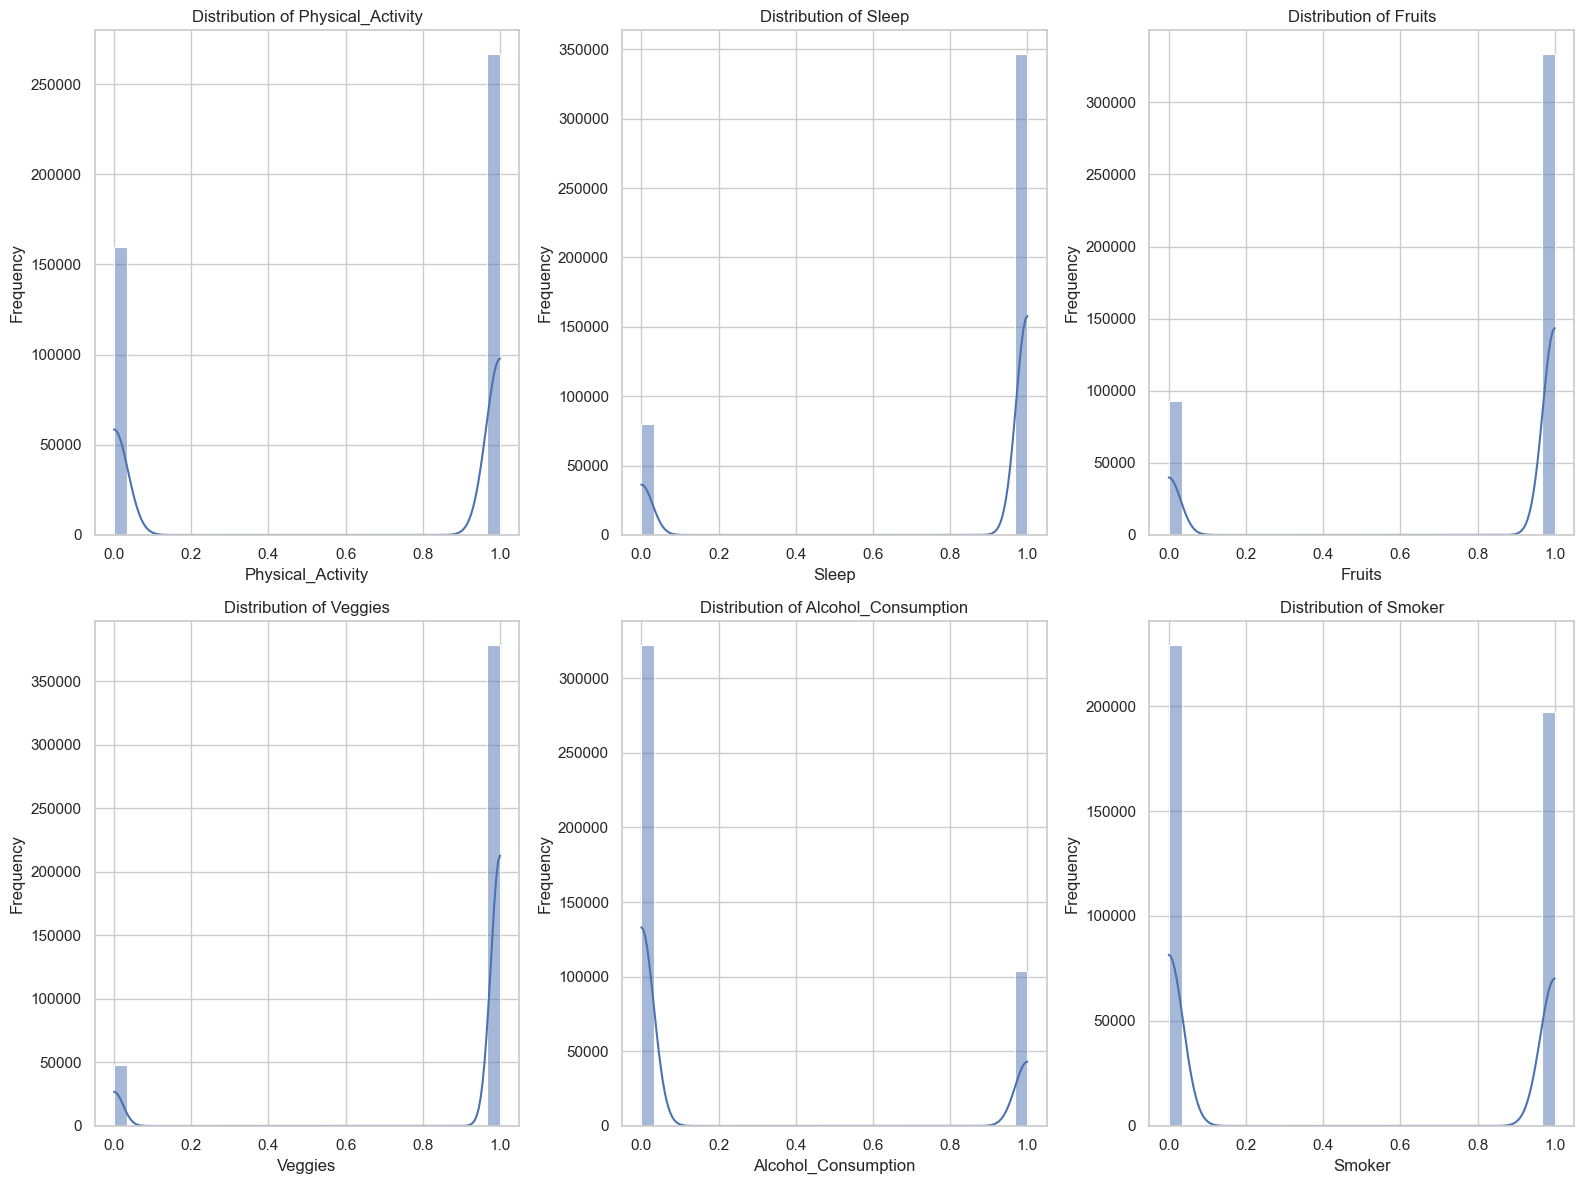

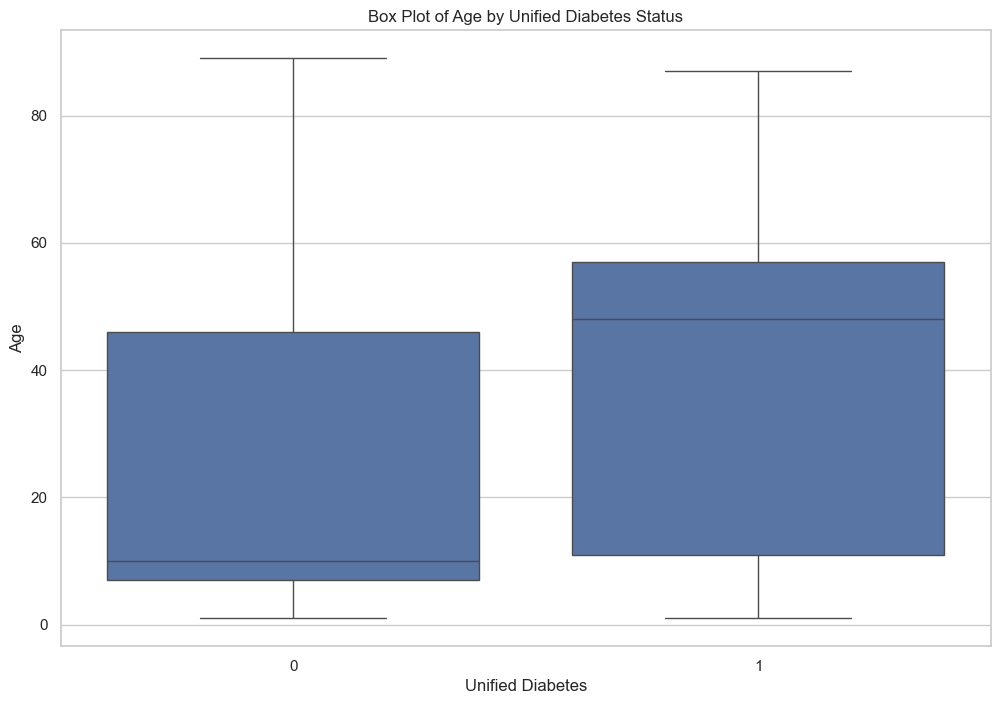

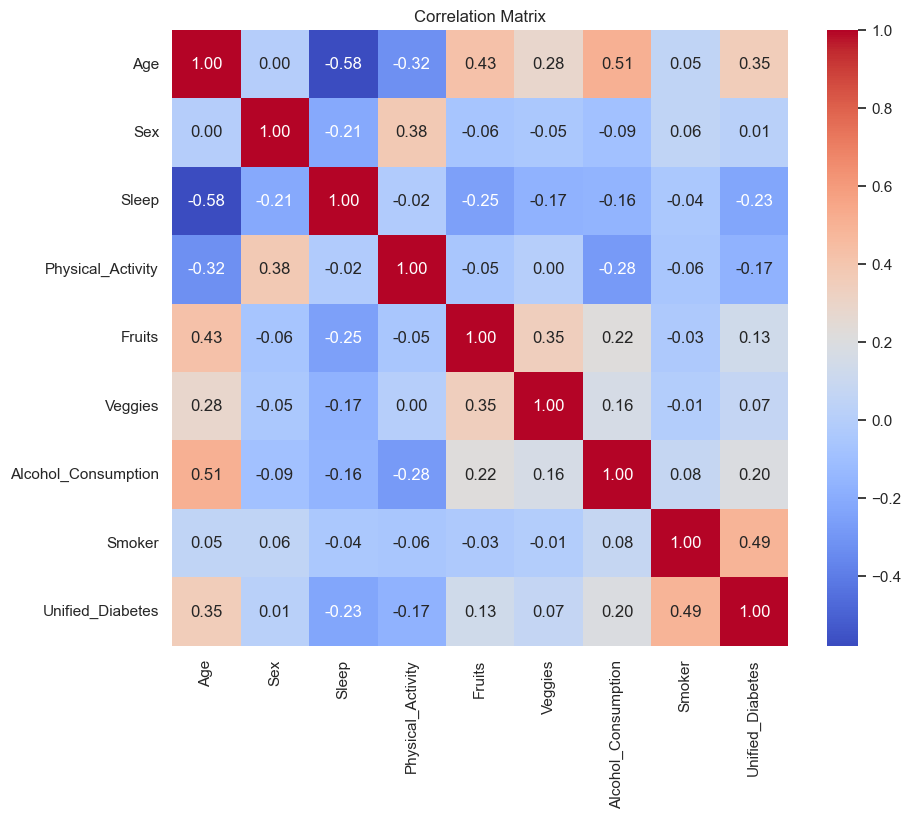

In [397]:
# Set the style for the plots
sns.set(style="whitegrid")

# 1. Histograms
features_to_plot = ['Physical_Activity', 'Sleep', 'Fruits', 'Veggies', 'Alcohol_Consumption', 'Smoker']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)  # Adjusted to fit all features in one row
    sns.histplot(merged_data[feature].dropna(), bins=30, kde=True)  # Drop missing values
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Box Plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_data, x='Unified_Diabetes', y='Age')
plt.title('Box Plot of Age by Unified Diabetes Status')
plt.xlabel('Unified Diabetes')
plt.ylabel('Age')
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(10, 8))
# Drop columns with missing values for correlation
correlation_matrix = merged_data.dropna().corr()  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

#### Handling possible outliers 

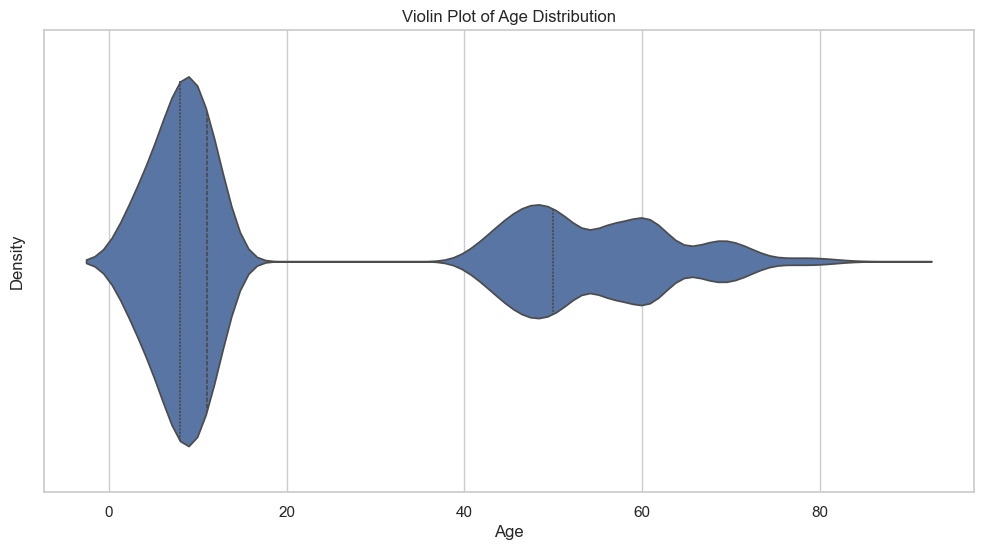

In [399]:
# Set the visual style
sns.set(style="whitegrid")

# Create the violin plot for the Age distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x=merged_data['Age'], inner='quartile')

# Adding title and labels
plt.title('Violin Plot of Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')

# Show the plot
plt.show()

In [400]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)  # or use a large number instead of None

# Get the value counts and sort them
sorted_age_counts = merged_data['Age'].value_counts().sort_index()
sorted_age_counts

Age
1      5700
2      7598
3     11123
4     13823
5     16157
6     19819
7     26314
8     30832
9     33244
10    32194
11    23533
12    15980
13    17363
40      904
41     2257
42     3157
43     4504
44     5838
45     7051
46     8308
47     8673
48     9505
49     9119
50     8954
51     7214
52     5967
53     5358
54     2135
55     1523
56    10349
57     7976
59     8774
60     8720
61     7596
62     5821
63     3917
64     1459
65      638
66     2107
67     2845
68     3792
69     3456
70     3607
71     2954
72     2035
73     1401
74      495
75      201
76      474
77      548
78      625
79      643
80      441
81      567
82      204
83       73
84       54
86       38
87       11
88        1
89        1
Name: count, dtype: int64

#### My data contains lots of data points for age below 20 but diabetes is prevalent for middle age and elderly people. Therefore, I will be cleaning the data as follows. 

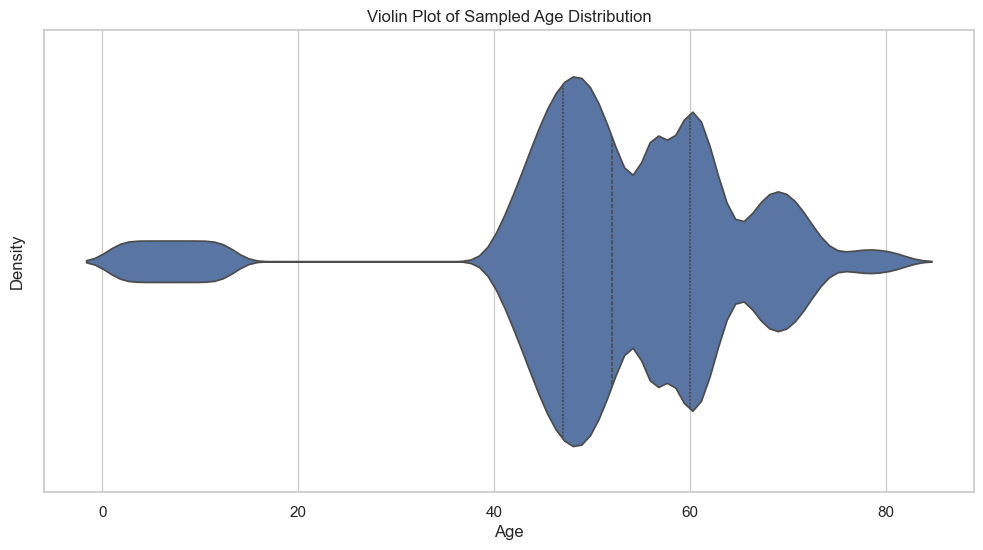

In [402]:
# Filter the data to include ages below 20
filtered_data = merged_data[merged_data['Age'] < 20]

# Create a list to hold the sampled data
sampled_data_list = []

# Group by age and sample up to 1000 from each age group
for age in range(20):
    age_group = filtered_data[filtered_data['Age'] == age]
    sampled_group = age_group.sample(n=min(1000, len(age_group)), random_state=42)
    sampled_data_list.append(sampled_group)

# Concatenate all sampled data into a single DataFrame
sampled_data = pd.concat(sampled_data_list, ignore_index=True)

# Create a new DataFrame with ages 20 to 82
data_within_age_limit = merged_data[(merged_data['Age'] >= 20) & (merged_data['Age'] <= 82)]

# Combine the sampled data with the filtered data for ages 20 to 82
merged_data = pd.concat([data_within_age_limit, sampled_data], ignore_index=True)

# Create the violin plot for the updated age distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x=merged_data['Age'], inner='quartile')
plt.title('Violin Plot of Sampled Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In [403]:
# Initialize a dictionary to store outlier counts
outlier_counts = {}

# Iterate through all columns in the DataFrame
for column in merged_data.columns:
    # Check if the column is binary (i.e., its unique values should be only 0 or 1)
    unique_values = merged_data[column].unique()
    outlier_count = len(merged_data[~merged_data[column].isin([0, 1])])
    
    # Store outlier count if the feature is binary
    if set(unique_values).issubset({0, 1}):
        outlier_counts[column] = outlier_count
        print(f"Unique values in {column}: {unique_values}")

# Convert outlier counts to a DataFrame
outlier_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])

# Display the DataFrame
print("=============================================")
print("Summary of Outlier Counts:")
outlier_counts_df

Unique values in Sex: [0 1]
Unique values in Sleep: [1 0]
Unique values in Physical_Activity: [0 1]
Unique values in Fruits: [1 0]
Unique values in Veggies: [1 0]
Unique values in Alcohol_Consumption: [0 1]
Unique values in Smoker: [0 1]
Unique values in Unified_Diabetes: [0 1]
Summary of Outlier Counts:


,Feature,Outlier Count
0,Sex,0
1,Sleep,0
2,Physical_Activity,0
3,Fruits,0
4,Veggies,0
5,Alcohol_Consumption,0
6,Smoker,0
7,Unified_Diabetes,0


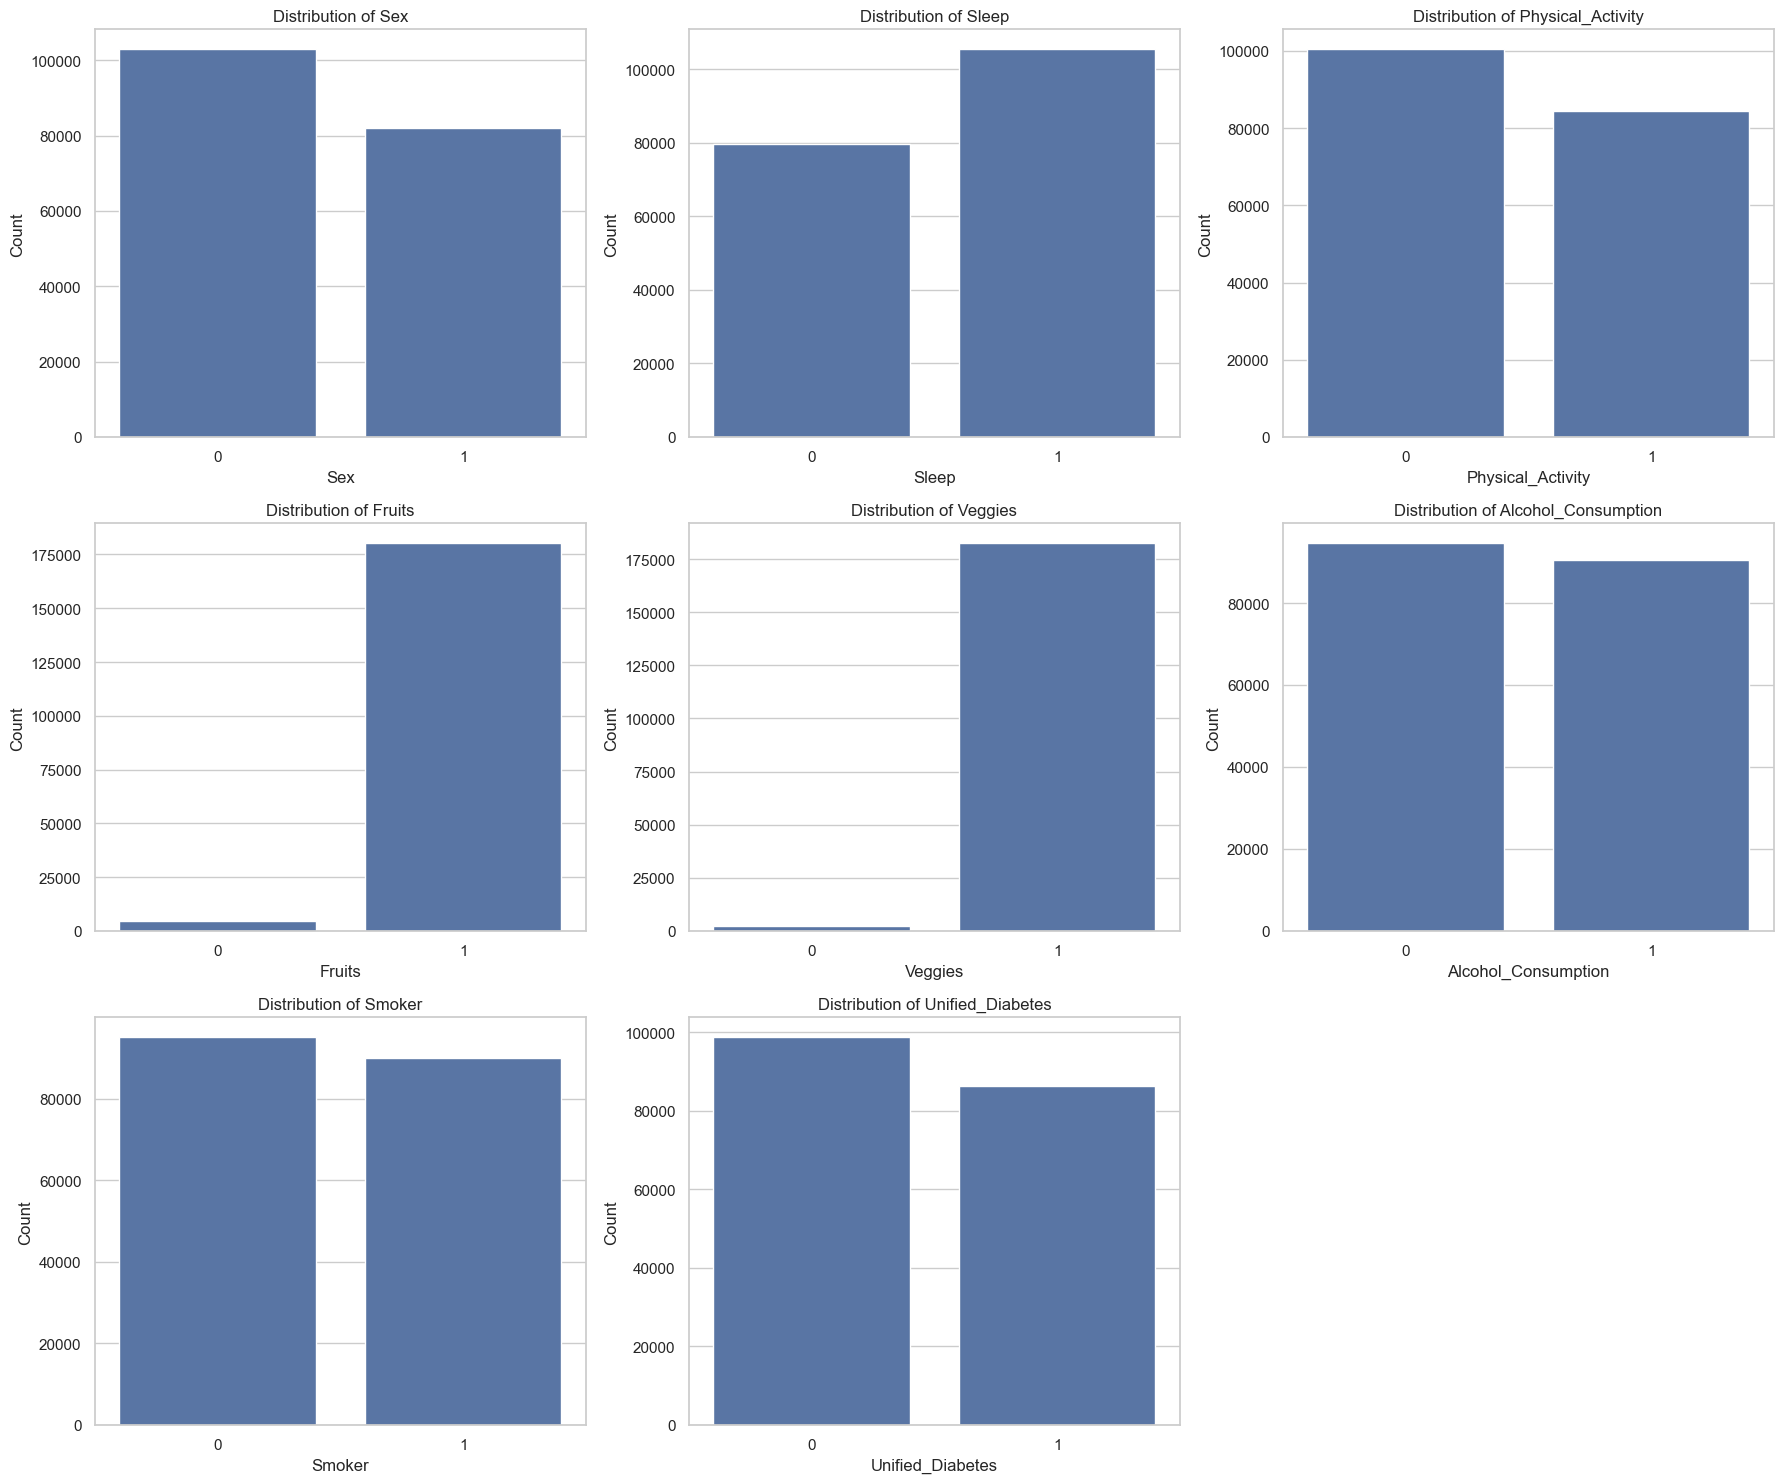

In [404]:
# Ploting features in three columns
num_columns = 3
num_rows = int(np.ceil(len(outlier_counts) / num_columns))

plt.figure(figsize=(18, 5 * num_rows))

for i, column in enumerate(outlier_counts.keys(), 1):
    plt.subplot(num_rows, num_columns, i)
    sns.countplot(data=merged_data, x=column)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Transformation and Feature engineering

In [406]:
# Define the function to categorize age
def categorize_age(age):
    if pd.isnull(age):
        return 'Unknown'  # Handle missing values
    elif age < 30:
        return 'Young'
    elif 30 <= age < 60:
        return 'Middle_Aged'
    else:
        return 'Elderly'

# Apply age categorization
merged_data['Age_Category'] = merged_data['Age'].apply(categorize_age)

# Drop the Age feature
merged_data.drop(columns=['Age'], inplace=True)

# Use Label Encoding for the Age_Category column
label_encoder = LabelEncoder()
merged_data['Age_Category'] = label_encoder.fit_transform(merged_data['Age_Category'])

# Creating interaction features
merged_data['Sleep_Physical_Activity'] = merged_data['Sleep'] * merged_data['Physical_Activity']
merged_data['Alcohol_Consumption_Smoker'] = merged_data['Alcohol_Consumption'] * merged_data['Smoker']
merged_data['Sleep_Alcohol_Consumption'] = merged_data['Sleep'] * merged_data['Alcohol_Consumption']


In [407]:
merged_data.sample(2)

,Sex,Sleep,Physical_Activity,Fruits,Veggies,Alcohol_Consumption,Smoker,Unified_Diabetes,Age_Category,Sleep_Physical_Activity,Alcohol_Consumption_Smoker,Sleep_Alcohol_Consumption
82105,0,1,0,1,1,0,0,0,1,0,0,0
48150,1,0,1,1,1,0,1,1,1,0,0,0


In [408]:
# Data integrity check function 
validate_data(merged_data)


No missing values in the dataset.
No negative values found in 'Sex'.
No non-numeric values found in 'Sex'.
No negative values found in 'Sleep'.
No non-numeric values found in 'Sleep'.
No negative values found in 'Physical_Activity'.
No non-numeric values found in 'Physical_Activity'.
No negative values found in 'Fruits'.
No non-numeric values found in 'Fruits'.
No negative values found in 'Veggies'.
No non-numeric values found in 'Veggies'.
No negative values found in 'Alcohol_Consumption'.
No non-numeric values found in 'Alcohol_Consumption'.
No negative values found in 'Smoker'.
No non-numeric values found in 'Smoker'.
No negative values found in 'Unified_Diabetes'.
No non-numeric values found in 'Unified_Diabetes'.
No negative values found in 'Age_Category'.
No non-numeric values found in 'Age_Category'.
No negative values found in 'Sleep_Physical_Activity'.
No non-numeric values found in 'Sleep_Physical_Activity'.
No negative values found in 'Alcohol_Consumption_Smoker'.
No non-nu

#### Prepare Features and Target Variable and Calculate VIF

In [410]:

# Prepare features and target variable
X = merged_data.drop(columns=['Unified_Diabetes'])

# Convert boolean columns to integers
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Handle missing values by dropping rows with NaN values
X = X.dropna()

y = merged_data['Unified_Diabetes']

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [411]:
# Calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Get the VIF DataFrame
vif_df = calculate_vif(X)

# Display VIF results
print(vif_df)

                       Feature        VIF
0                          Sex   5.775003
1                        Sleep  10.873768
2            Physical_Activity  10.136594
3                       Fruits  46.547893
4                      Veggies  53.505732
5          Alcohol_Consumption   7.001529
6                       Smoker   4.660098
7                 Age_Category   3.525209
8      Sleep_Physical_Activity   4.084579
9   Alcohol_Consumption_Smoker   4.703473
10   Sleep_Alcohol_Consumption   6.921343


#### Features Fruits and Veggies has a very high VIF. For binary variables, a high VIF might not indicate multicollinearity in the same way it does for continuous variables. Instead, it may reflect the fact that two binary variables are highly correlated due to the way they are structured. Despite their low correlation with Unified_Diabetes, diet is a significant factor in diabetes risk, keeping these features(Fruits, Veggies) could be important.

In [413]:
# Combining Fruits and Veggies into a single feature
merged_data['Fruits_Veggies'] = merged_data['Fruits'] + merged_data['Veggies']
# Drop the original columns Fruits and Veggies 
merged_data.drop(columns=['Fruits', 'Veggies'], inplace=True)

In [414]:
merged_data.head(2)

,Sex,Sleep,Physical_Activity,Alcohol_Consumption,Smoker,Unified_Diabetes,Age_Category,Sleep_Physical_Activity,Alcohol_Consumption_Smoker,Sleep_Alcohol_Consumption,Fruits_Veggies
0,0,1,0,0,0,0,1,0,0,0,2
1,0,1,0,0,0,0,1,0,0,0,2


In [415]:
# Prepare features and target variable
X = merged_data.drop(columns=['Unified_Diabetes'])

# Convert boolean columns to integers
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Handle missing values by dropping rows with NaN values
X = X.dropna()

y = merged_data['Unified_Diabetes']

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [416]:
# Recomputing VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Get the VIF DataFrame
vif_df = calculate_vif(X)

# Display VIF results
vif_df

,Feature,VIF
0,Sex,5.774615
1,Sleep,10.825107
2,Physical_Activity,10.133558
3,Alcohol_Consumption,6.970608
4,Smoker,4.637214
5,Age_Category,3.444062
6,Sleep_Physical_Activity,4.080939
7,Alcohol_Consumption_Smoker,4.691177
8,Sleep_Alcohol_Consumption,6.889240
9,Fruits_Veggies,11.423389


## 3. Regression Models
   **Modeling**: Using regression techniques to predict the risk score.  
   **Risk Score Calculation**: This will provide a numerical value indicating the likelihood of developing diabetes based on the features.

In [418]:
# ===============================
# MODEL-1: Linear Regression Model
# ===============================

# Initialize the regression model
model_linreg = LinearRegression()

# Fit the model to the training data
model_linreg.fit(X_train, y_train)

# Predict the risk scores on both training and testing data
train_pred = model_linreg.predict(X_train)
test_pred = model_linreg.predict(X_test)

In [419]:
# ===============================================
# MODEL-1 Evaluation Section for Linear Regression
# ===============================================

# Calculate Mean Squared Error
linreg_train_mse = mean_squared_error(y_train, train_pred)
linreg_test_mse = mean_squared_error(y_test, test_pred)

# Calculate RMSE
linreg_train_rmse = np.sqrt(linreg_train_mse)
linreg_test_rmse = np.sqrt(linreg_test_mse)

# Calculate Mean Absolute Error (MAE)
linreg_train_mae = mean_absolute_error(y_train, train_pred)
linreg_test_mae = mean_absolute_error(y_test, test_pred)


# Calculate Mean Absolute Percentage Error (MAPE)
linreg_train_mape = mean_absolute_percentage_error(y_train, train_pred)
linreg_test_mape = mean_absolute_percentage_error(y_test, test_pred)

# Accuracy: For continuous values, we can round the predictions to 0 or 1 for a rough accuracy estimate
train_pred_rounded = np.round(train_pred)
test_pred_rounded = np.round(test_pred)
linreg_train_accuracy = accuracy_score(y_train, train_pred_rounded)
linreg_test_accuracy = accuracy_score(y_test, test_pred_rounded)

# Calculate R² scores
linreg_train_r2 = r2_score(y_train, train_pred)
linreg_test_r2 = r2_score(y_test, test_pred)

# Print evaluation metrics with clear formatting
print("===========================================")
print("              Model Evaluation              ")
print("             Linear Regression             ")
print("===========================================")
print(f"Linreg Train Mean Squared Error (MSE): {linreg_train_mse:.2f}")
print(f"Linreg Test Mean Squared Error (MSE): {linreg_test_mse:.2f}")
print(f"Linreg Train Root Mean Squared Error (RMSE): {linreg_train_rmse:.2f}")
print(f"Linreg Test Root Mean Squared Error (RMSE): {linreg_test_rmse:.2f}")
print(f"Linreg Train Mean Absolute Error (MAE): {linreg_train_mae:.2f}")
print(f"Linreg Test Mean Absolute Error (MAE): {linreg_test_mae:.2f}")
print(f"Linreg Train Accuracy: {linreg_train_accuracy:.2f}")
print(f"Linreg Test Accuracy: {linreg_test_accuracy:.2f}")
print(f"Linreg Train R²: {linreg_train_r2:.2f}")
print(f"Linreg Test R²: {linreg_test_r2:.2f}")
print("===========================================")

              Model Evaluation              
             Linear Regression             
Linreg Train Mean Squared Error (MSE): 0.02
Linreg Test Mean Squared Error (MSE): 0.02
Linreg Train Root Mean Squared Error (RMSE): 0.15
Linreg Test Root Mean Squared Error (RMSE): 0.15
Linreg Train Mean Absolute Error (MAE): 0.06
Linreg Test Mean Absolute Error (MAE): 0.06
Linreg Train Accuracy: 0.97
Linreg Test Accuracy: 0.97
Linreg Train R²: 0.91
Linreg Test R²: 0.91


In [420]:
# Preprocessing function
def create_preprocessor(X, degree=None):
    # Select numerical features
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    # Create polynomial transformer if a degree is provided
    poly_transformer = PolynomialFeatures(degree=degree) if degree else PolynomialFeatures()
    
    # Create a pipeline for numerical features that includes scaling and polynomial transformation
    numerical_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', poly_transformer)
    ])
    
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features)
        ]
    )
    
    return preprocessor

In [421]:
# MODEL-2: PolynomialFeatures with the best polynomial degree Model
# Create the preprocessor
preprocessor = create_preprocessor(X_train)

# Create the pipeline for the initial model
pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # or any other model
])

# Define the parameter grid for degrees
param_grid_1 = {
    'preprocessor__num__poly__degree': range(2, 5)  # Testing degrees 2, 3, and 4
}

grid_search_1 = GridSearchCV(pipe_1, param_grid_1, cv=3)  # 3-fold cross-validation

# Fit the GridSearchCV
grid_search_1.fit(X_train, y_train)

# Get the best degree and score
best_degree = grid_search_1.best_params_['preprocessor__num__poly__degree']
best_score = grid_search_1.best_score_

print(f'Best Degree: {best_degree}')
print(f'Best Cross-Validation Score: {best_score:.4f}')

# Fit the final model using the best degree
final_model = Pipeline([
    ('preprocessor', preprocessor),  # Reuse the existing preprocessor
    ('model', LinearRegression())
])

# Update the polynomial degree in the preprocessor
final_model.named_steps['preprocessor'].transformers[0][1].named_steps['poly'].degree = best_degree

# Fit the final model
final_model.fit(X_train, y_train)

# Make predictions on training and test sets
train_pred_poly = final_model.predict(X_train)
test_pred_poly = final_model.predict(X_test)

Best Degree: 3
Best Cross-Validation Score: 0.9691


In [422]:
# =================================================
# MODEL-2 Evaluation Section for PolynomialFeatures
# =================================================

# Calculate Mean Squared Error for both training and test sets
poly_train_mse = mean_squared_error(y_train, train_pred_poly)
poly_test_mse = mean_squared_error(y_test, test_pred_poly)

# Calculate RMSE
poly_train_rmse = np.sqrt(poly_train_mse)
poly_test_rmse = np.sqrt(poly_test_mse)

# Calculate Mean Absolute Error (MAE)
poly_train_mae = mean_absolute_error(y_train, train_pred_poly)
poly_test_mae = mean_absolute_error(y_test, test_pred_poly)

# Accuracy: For continuous values, we can round the predictions to 0 or 1 for a rough accuracy estimate
train_pred_rounded = np.round(train_pred_poly)
test_pred_rounded = np.round(test_pred_poly)
poly_train_accuracy = accuracy_score(y_train, train_pred_rounded)
poly_test_accuracy = accuracy_score(y_test, test_pred_rounded)


# Calculate R² scores
poly_train_r2 = r2_score(y_train, train_pred_poly)
poly_test_r2 = r2_score(y_test, test_pred_poly)

# Print evaluation metrics with clear formatting
print("===========================================")
print("              Model Evaluation              ")
print("             PolynomialFeatures             ")
print("===========================================")
print(f"Poly Train Mean Squared Error (MSE): {poly_train_mse:.2f}")
print(f"Poly Test Mean Squared Error (MSE): {poly_test_mse:.2f}")
print(f"Poly Train Root Mean Squared Error (RMSE): {poly_train_rmse:.2f}")
print(f"Poly Test Root Mean Squared Error (RMSE): {poly_test_rmse:.2f}")
print(f"Poly Train Mean Absolute Error (MAE): {poly_train_mae:.2f}")
print(f"Poly Test Mean Absolute Error (MAE): {poly_test_mae:.2f}")
print(f"Poly Train Accuracy: {poly_train_accuracy:.2f}")
print(f"Poly Test Accuracy: {poly_test_accuracy:.2f}")
print(f"Poly Train R²: {poly_train_r2:.2f}")
print(f"Poly Test R²: {poly_test_r2:.2f}")
print("===========================================")

              Model Evaluation              
             PolynomialFeatures             
Poly Train Mean Squared Error (MSE): 0.01
Poly Test Mean Squared Error (MSE): 0.01
Poly Train Root Mean Squared Error (RMSE): 0.09
Poly Test Root Mean Squared Error (RMSE): 0.09
Poly Train Mean Absolute Error (MAE): 0.02
Poly Test Mean Absolute Error (MAE): 0.02
Poly Train Accuracy: 0.99
Poly Test Accuracy: 0.99
Poly Train R²: 0.97
Poly Test R²: 0.97


In [423]:
# ===============================
# MODEL-3: Lasso regression Model
# ===============================

# Create the preprocessor with polynomial degree 3
preprocessor = create_preprocessor(X_train, degree=3)

# Create the pipeline with Lasso Regression
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess features
    ('model', Lasso(max_iter=10000))  # Use Lasso Regression as the model
])

# Define a limited grid of alpha values
lasso_param_dict = {'model__alpha': np.logspace(-2, 5, 10)}  # Range of alpha values
lasso_grid = GridSearchCV(lasso_pipe, param_grid=lasso_param_dict, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the sampled dataset
lasso_grid.fit(X_train, y_train)

# Use the best estimator for predictions
lasso_best_model = lasso_grid.best_estimator_

# Make predictions
lasso_train_preds = lasso_best_model.predict(X_train)
lasso_test_preds = lasso_best_model.predict(X_test)

# Calculate Mean Squared Error for training and testing sets
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

# Print the best parameters and the best cross-validation score
print(f'Best parameters: {lasso_grid.best_params_}')
print(f'Best cross-validation score: {lasso_grid.best_score_:.2f}')

# Get coefficients from the best model
coefs = lasso_best_model.named_steps['model'].coef_
feature_names = lasso_best_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Count the number of coefficients that are zero
num_zero_coefs = (coefs == 0).sum()

# Get the top 10 coefficients by absolute value
lasso_top_10_coefs = coef_df.reindex(coef_df['Coefficient'].abs().nlargest(10).index)
lasso_top_10_coefs['Feature'] = lasso_top_10_coefs['Feature'].str.replace(r'^(num__|cat__)', '', regex=True)

# Print the results
print(f'Number of coefficients: {len(coef_df)}')
print(f'Number of coefficients forced to zero: {num_zero_coefs}')
print('===========================================')
print('Lasso top 10 Coefficient Values:')
lasso_top_10_coefs

Best parameters: {'model__alpha': 0.01}
Best cross-validation score: -0.01
Number of coefficients: 286
Number of coefficients forced to zero: 270
Lasso top 10 Coefficient Values:


,Feature,Coefficient
5,Smoker,0.435559
124,Sleep^2 Smoker,0.052504
46,Smoker Age_Category,-0.051774
236,Smoker Age_Category^2,-0.051247
51,Age_Category^2,-0.020217
251,Age_Category^3,-0.015691
248,Smoker Sleep_Alcohol_Consumption^2,0.011765
87,Sex Physical_Activity Smoker,0.006278
237,Smoker Age_Category Sleep_Physical_Activity,-0.006023
252,Age_Category^2 Sleep_Physical_Activity,-0.004419


In [424]:
# =============================================
# Model Evaluation Section for Lasso regression
# =============================================

# Calculate Mean Squared Error
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

# Calculate RMSE
lasso_train_rmse = np.sqrt(lasso_train_mse)
lasso_test_rmse = np.sqrt(lasso_test_mse)

# Calculate Mean Absolute Error (MAE)
lasso_train_mae = mean_absolute_error(y_train, lasso_train_preds)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_preds)

# Accuracy: For continuous values, round predictions to 0 or 1
lasso_train_pred_rounded = np.round(lasso_train_preds)
lasso_test_pred_rounded = np.round(lasso_test_preds)
lasso_train_accuracy = accuracy_score(y_train, lasso_train_pred_rounded)
lasso_test_accuracy = accuracy_score(y_test, lasso_test_pred_rounded)

# Calculate R² scores
lasso_train_r2 = r2_score(y_train, lasso_train_preds)
lasso_test_r2 = r2_score(y_test, lasso_test_preds)

# Print evaluation metrics with clear formatting
print("===========================================")
print("              Lasso Model Evaluation          ")
print("                Lasso regression              ")
print("===========================================")
print(f"Lasso Train Mean Squared Error (MSE): {lasso_train_mse:.2f}")
print(f"Lasso Test Mean Squared Error (MSE): {lasso_test_mse:.2f}")
print(f"Lasso Train Root Mean Squared Error (RMSE): {lasso_train_rmse:.2f}")
print(f"Lasso Test Root Mean Squared Error (RMSE): {lasso_test_rmse:.2f}")
print(f"Lasso Train Mean Absolute Error (MAE): {lasso_train_mae:.2f}")
print(f"Lasso Test Mean Absolute Error (MAE): {lasso_test_mae:.2f}")
print(f"Lasso Train Accuracy: {lasso_train_accuracy:.2f}")
print(f"Lasso Test Accuracy: {lasso_test_accuracy:.2f}")
print(f"Lasso Train R²: {lasso_train_r2:.2f}")
print(f"Lasso Test R²: {lasso_test_r2:.2f}")
print("===========================================")


              Lasso Model Evaluation          
                Lasso regression              
Lasso Train Mean Squared Error (MSE): 0.01
Lasso Test Mean Squared Error (MSE): 0.01
Lasso Train Root Mean Squared Error (RMSE): 0.09
Lasso Test Root Mean Squared Error (RMSE): 0.09
Lasso Train Mean Absolute Error (MAE): 0.03
Lasso Test Mean Absolute Error (MAE): 0.03
Lasso Train Accuracy: 0.99
Lasso Test Accuracy: 0.99
Lasso Train R²: 0.97
Lasso Test R²: 0.96


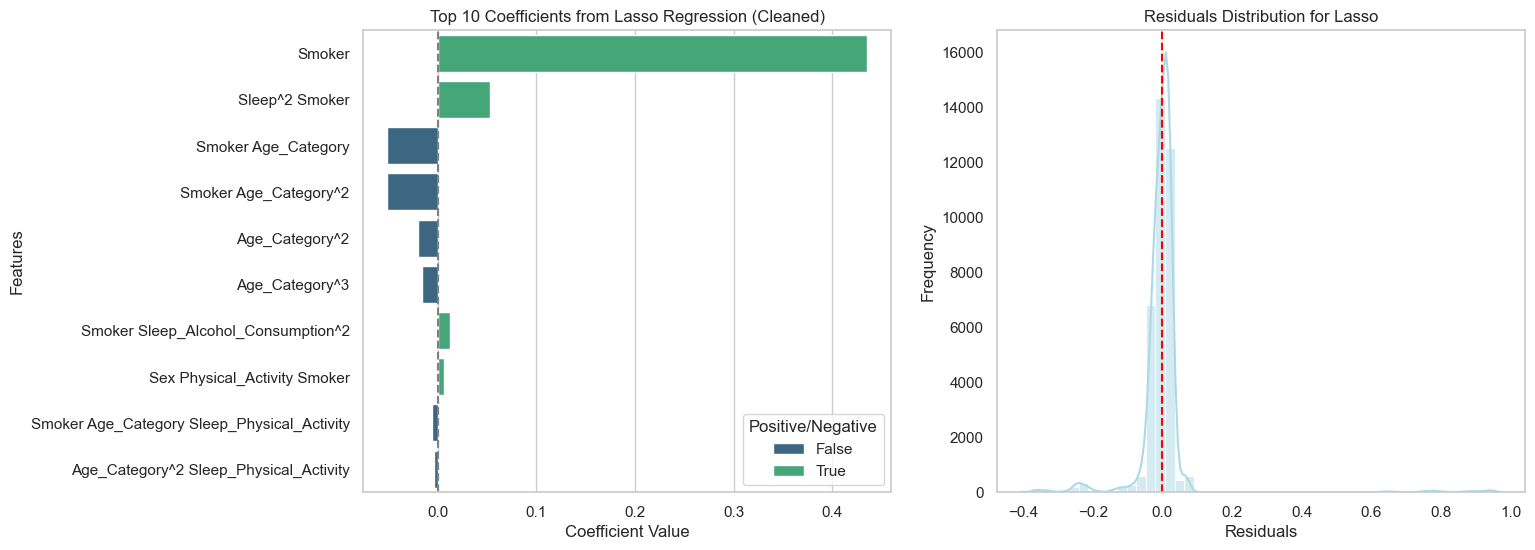

In [425]:
# Visualization for Top 10 Coefficients from Lasso Regression and Residuals Distribution side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Top 10 Coefficients from Lasso Regression
sns.barplot(data=lasso_top_10_coefs, x='Coefficient', y='Feature', palette='viridis', hue=lasso_top_10_coefs['Coefficient'] > 0, ax=axs[0])
axs[0].set_title('Top 10 Coefficients from Lasso Regression (Cleaned)')
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')
axs[0].axvline(0, color='grey', linestyle='--')  # Add a vertical line at x=0 for reference
axs[0].legend(title='Positive/Negative', loc='lower right')

# Residuals Distribution
lasso_residuals = y_test - lasso_test_preds
sns.histplot(lasso_residuals, kde=True, ax=axs[1], color='lightblue', bins=50)
axs[1].axvline(0, color='red', linestyle='--')
axs[1].set_title('Residuals Distribution for Lasso')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].grid()

# Display the plot
plt.show()

In [426]:
# ===============================
# MODEL-4: Ridge regression Model
# ===============================

# Create the preprocessor with polynomial degree 3
preprocessor = create_preprocessor(X_train, degree=3)

# Create the pipeline with Ridge Regression
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess features
    ('model', Ridge())  # Use Ridge Regression as the model
])

# Define the parameter grid for alpha values
ridge_param_dict = {'model__alpha': np.logspace(0, 10, 50)}  
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, cv=5, scoring='neg_mean_squared_error')

# Fit the model on the training dataset
ridge_grid.fit(X_train, y_train)

# Make predictions
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)

# Calculate Mean Squared Error for training and testing sets
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

# Extract coefficients from the best estimator
coefs = ridge_grid.best_estimator_.named_steps['model'].coef_
feature_names = ridge_grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Get the top 10 coefficients by absolute value
ridge_top_10_coefs = coef_df.reindex(coef_df['Coefficient'].abs().nlargest(10).index)
ridge_top_10_coefs['Feature'] = ridge_top_10_coefs['Feature'].str.replace(r'^(num__|cat__)', '', regex=True)

# Print the number of coefficients
print(f'Number of coefficients: {len(coef_df)}')
print('===========================================')

# Print the top 10 coefficients
print('Ridge top 10 Coefficient Values (Positive and Negative):')
ridge_top_10_coefs

Number of coefficients: 286
Ridge top 10 Coefficient Values (Positive and Negative):


,Feature,Coefficient
236,Smoker Age_Category^2,-0.074038
124,Sleep^2 Smoker,0.059025
230,Smoker^3,0.057897
5,Smoker,0.057747
70,Sex^2 Smoker,0.056205
203,Alcohol_Consumption^2 Smoker,0.055748
168,Physical_Activity^2 Smoker,0.054649
46,Smoker Age_Category,-0.043963
39,Alcohol_Consumption Smoker,-0.041225
49,Smoker Sleep_Alcohol_Consumption,-0.036580


In [427]:
# =============================================
# Model Evaluation Section for Ridge regression 
# =============================================

# Calculate Mean Squared Error
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

# Calculate RMSE
ridge_train_rmse = np.sqrt(ridge_train_mse)
ridge_test_rmse = np.sqrt(ridge_test_mse)

# Calculate Mean Absolute Error (MAE)
ridge_train_mae = mean_absolute_error(y_train, ridge_train_preds)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_preds)

# Calculate Mean Absolute Percentage Error (MAPE)
ridge_train_mape = mean_absolute_percentage_error(y_train, ridge_train_preds)
ridge_test_mape = mean_absolute_percentage_error(y_test, ridge_test_preds)

# Accuracy: For continuous values, we can round the predictions to 0 or 1 for a rough accuracy estimate
train_pred_rounded = np.round(ridge_train_preds)
test_pred_rounded = np.round(ridge_test_preds)
ridge_train_accuracy = accuracy_score(y_train, train_pred_rounded)
ridge_test_accuracy = accuracy_score(y_test, test_pred_rounded)


# Calculate R² scores
ridge_train_r2 = r2_score(y_train, ridge_train_preds)
ridge_test_r2 = r2_score(y_test, ridge_test_preds)

# Print evaluation metrics with clear formatting
print("===========================================")
print("              Model Evaluation              ")
print("              Ridge regression               ")
print("===========================================")
print(f"Ridge Train Mean Squared Error (MSE): {ridge_train_mse:.2f}")
print(f"Ridge Test Mean Squared Error (MSE): {ridge_test_mse:.2f}")
print(f"Ridge Train Root Mean Squared Error (RMSE): {ridge_train_rmse:.2f}")
print(f"Ridge Test Root Mean Squared Error (RMSE): {ridge_test_rmse:.2f}")
print(f"Ridge Train Mean Absolute Error (MAE): {ridge_train_mae:.2f}")
print(f"Ridge Test Mean Absolute Error (MAE): {ridge_test_mae:.2f}")
print(f"Poly Train Accuracy: {ridge_train_accuracy:.2f}")
print(f"Poly Test Accuracy: {ridge_test_accuracy:.2f}")
print(f"Ridge Train R²: {ridge_train_r2:.2f}")
print(f"Ridge Test R²: {ridge_test_r2:.2f}")
print("===========================================")

              Model Evaluation              
              Ridge regression               
Ridge Train Mean Squared Error (MSE): 0.01
Ridge Test Mean Squared Error (MSE): 0.01
Ridge Train Root Mean Squared Error (RMSE): 0.09
Ridge Test Root Mean Squared Error (RMSE): 0.09
Ridge Train Mean Absolute Error (MAE): 0.02
Ridge Test Mean Absolute Error (MAE): 0.02
Poly Train Accuracy: 0.99
Poly Test Accuracy: 0.99
Ridge Train R²: 0.97
Ridge Test R²: 0.97


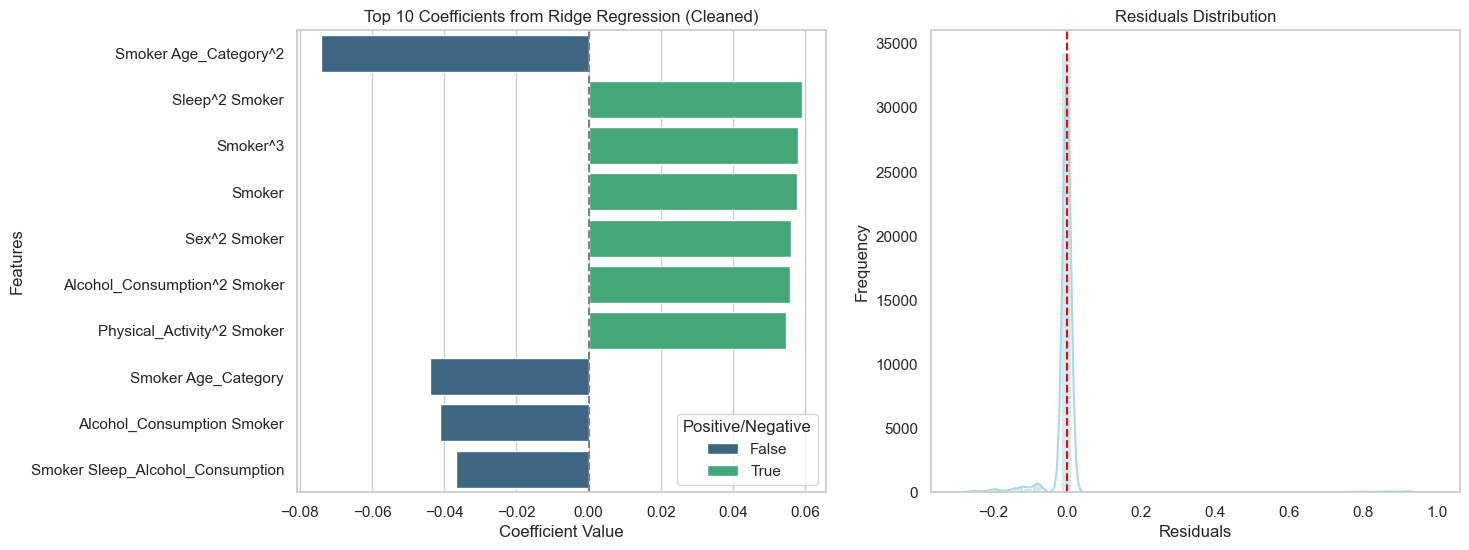

In [428]:
# =====================================
# Visualizations Ridge regression Model
# =====================================

# Visualization for Top 10 Coefficients from Ridge Regression and Residuals Distribution side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Top 10 Coefficients from Ridge Regression
sns.barplot(data=ridge_top_10_coefs, x='Coefficient', y='Feature', palette='viridis', hue=ridge_top_10_coefs['Coefficient'] > 0, ax=axs[0])
axs[0].set_title('Top 10 Coefficients from Ridge Regression (Cleaned)')
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Features')
axs[0].axvline(0, color='grey', linestyle='--')  # Add a vertical line at x=0 for reference
axs[0].legend(title='Positive/Negative', loc='lower right')

# Residuals Distribution
residuals = y_test - ridge_test_preds
sns.histplot(residuals, kde=True, ax=axs[1], color='lightblue', bins=50)
axs[1].axvline(0, color='red', linestyle='--')
axs[1].set_title('Residuals Distribution')
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].grid()

# Display the plot
plt.show()

In [429]:
# Comparing the performance of the four models 
# Creating a DataFrame to summarize the metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Ridge Regression', 'Lasso Regression'],
    'Train MSE': [linreg_train_mse, poly_train_mse, ridge_train_mse, lasso_train_mse],
    'Test MSE': [linreg_test_mse, poly_test_mse, ridge_test_mse, lasso_test_mse],
    'Train RMSE': [linreg_train_rmse, poly_train_rmse, ridge_train_rmse, lasso_train_rmse],
    'Test RMSE': [linreg_test_rmse, poly_test_rmse, ridge_test_rmse, lasso_test_rmse],
    'Train MAE': [linreg_train_mae, poly_train_mae, ridge_train_mae, lasso_train_mae],
    'Test MAE': [linreg_test_mae, poly_test_mae, ridge_test_mae, lasso_test_mae],
    'Train Accuracy': [linreg_train_accuracy, poly_train_accuracy, ridge_train_accuracy, lasso_train_accuracy],
    'Test Accuracy': [linreg_test_accuracy, poly_test_accuracy, ridge_test_accuracy, lasso_test_accuracy],
    'Train R²': [linreg_train_r2, poly_train_r2, ridge_train_r2, lasso_train_r2],
    'Test R²': [linreg_test_r2, poly_test_r2, ridge_test_r2, lasso_test_r2],
})

# Print the summary table
metrics_df


,Model,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAE,Test MAE,Train Accuracy,Test Accuracy,Train R²,Test R²
0,Linear Regression,0.022750,0.023398,0.150830,0.152964,0.064181,0.064443,0.971146,0.970910,0.908611,0.905839
1,Polynomial Regression,0.007624,0.008145,0.087313,0.090251,0.015704,0.016193,0.990972,0.990411,0.969375,0.967221
2,Ridge Regression,0.007624,0.008146,0.087313,0.090253,0.015685,0.016176,0.990972,0.990411,0.969375,0.967219
3,Lasso Regression,0.008503,0.008968,0.092213,0.094701,0.032312,0.032729,0.990972,0.990411,0.965841,0.963909


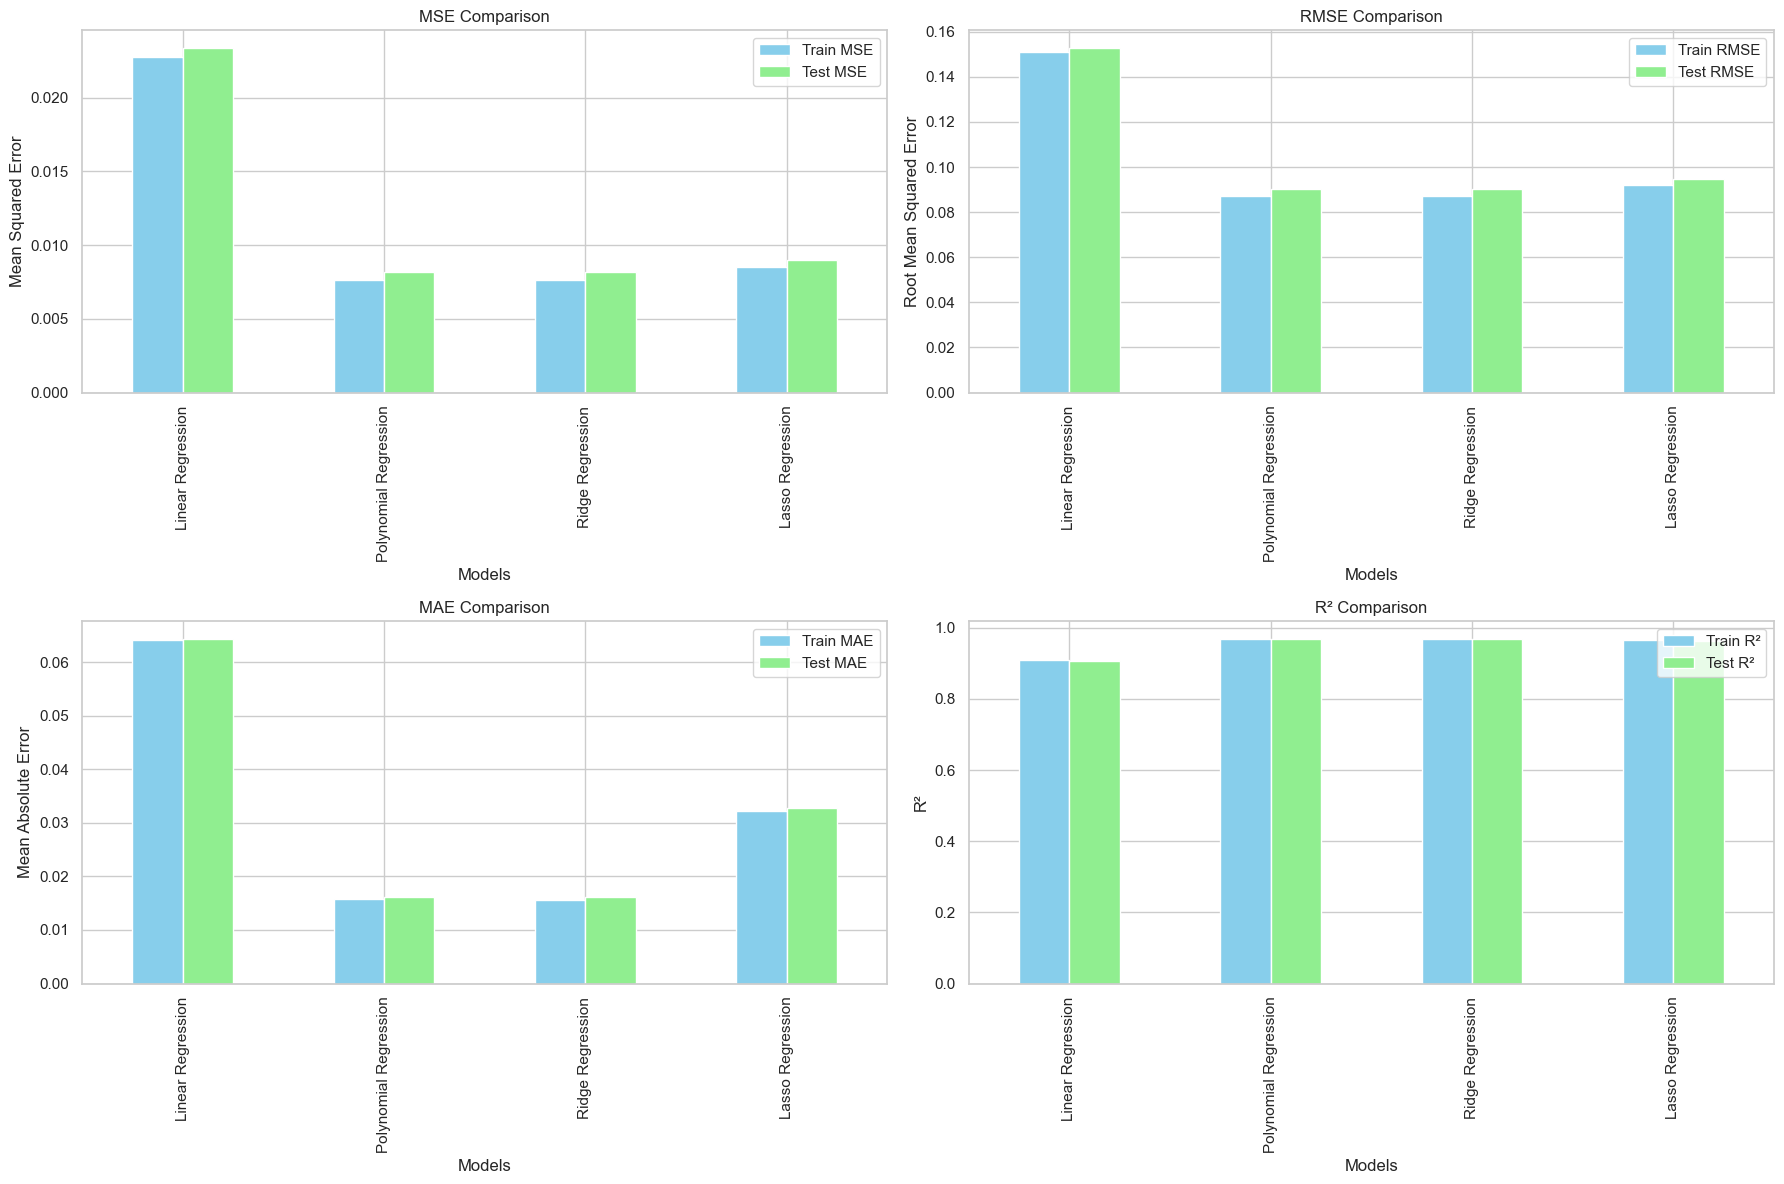

In [430]:
# Plotting the comparison of models for each metric

# Set up the figure and axes for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# MSE Comparison
metrics_df[['Model', 'Train MSE', 'Test MSE']].set_index('Model').plot(kind='bar', ax=axs[0, 0], color=['skyblue', 'lightgreen'])
axs[0, 0].set_title('MSE Comparison')
axs[0, 0].set_ylabel('Mean Squared Error')
axs[0, 0].set_xlabel('Models')

# RMSE Comparison
metrics_df[['Model', 'Train RMSE', 'Test RMSE']].set_index('Model').plot(kind='bar', ax=axs[0, 1], color=['skyblue', 'lightgreen'])
axs[0, 1].set_title('RMSE Comparison')
axs[0, 1].set_ylabel('Root Mean Squared Error')
axs[0, 1].set_xlabel('Models')

# MAE Comparison
metrics_df[['Model', 'Train MAE', 'Test MAE']].set_index('Model').plot(kind='bar', ax=axs[1, 0], color=['skyblue', 'lightgreen'])
axs[1, 0].set_title('MAE Comparison')
axs[1, 0].set_ylabel('Mean Absolute Error')
axs[1, 0].set_xlabel('Models')

# R² Comparison
metrics_df[['Model', 'Train R²', 'Test R²']].set_index('Model').plot(kind='bar', ax=axs[1, 1], color=['skyblue', 'lightgreen'])
axs[1, 1].set_title('R² Comparison')
axs[1, 1].set_ylabel('R²')
axs[1, 1].set_xlabel('Models')

# Display the plots
plt.tight_layout()
plt.show()

#### Given these metrics, Polynomial Regression is the best performer in terms of error metrics (MSE, RMSE, and MAE), accuracy, and R² values. Ridge Regression is a close second and offers a more regularized approach, which may make it more stable if there's a risk of overfitting. Therefore, we will proceed with Ridge Regression model. 

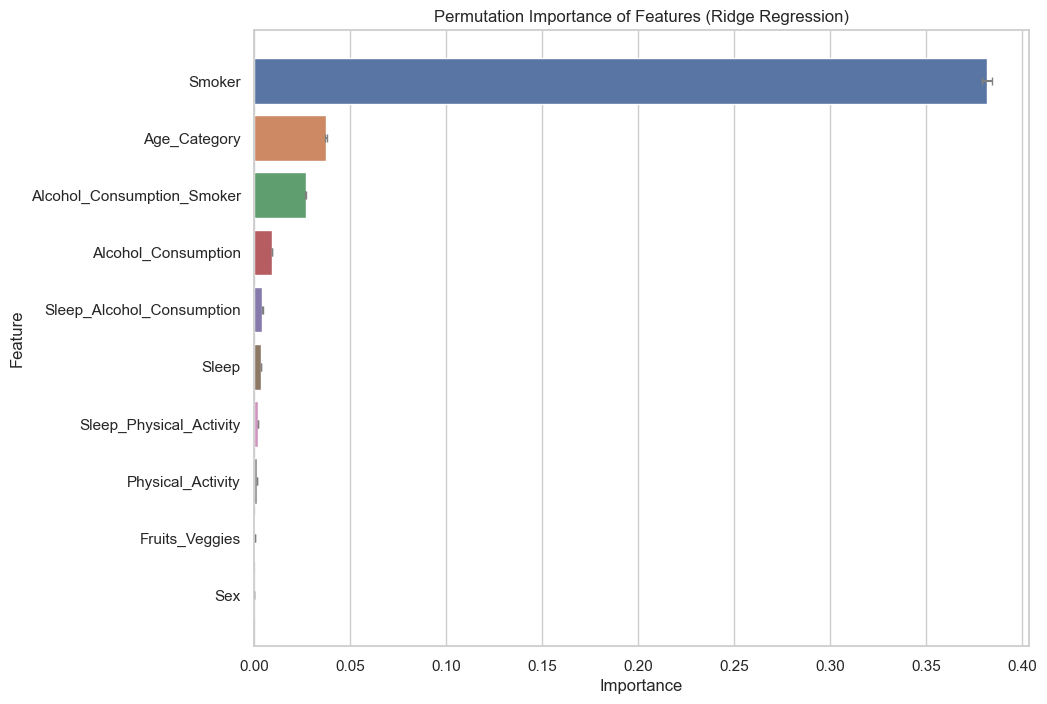

,Feature,Importance,Std Dev
4,Smoker,0.381613,0.002576
5,Age_Category,0.037500,0.000452
7,Alcohol_Consumption_Smoker,0.026982,0.000216
3,Alcohol_Consumption,0.009492,0.000132
8,Sleep_Alcohol_Consumption,0.004456,0.000046
1,Sleep,0.003571,0.000058
6,Sleep_Physical_Activity,0.002279,0.000035
2,Physical_Activity,0.001508,0.000034
9,Fruits_Veggies,0.000493,0.000022
0,Sex,0.000031,0.000018


In [432]:
# Calculate permutation importance
result = permutation_importance(ridge_grid, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Plotting the permutation importance with a fixed hue
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', dodge=False, legend=False)
plt.errorbar(x=importance_df['Importance'], y=range(len(importance_df)), 
             xerr=importance_df['Std Dev'], fmt='none', ecolor='grey', capsize=3)
plt.title('Permutation Importance of Features (Ridge Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
importance_df

### Smoking and age are the strongest predictors of diabetes risk in this analysis, with smoking standing out as the most impactful feature. The combined effects of alcohol consumption with smoking, as well as age-related data, further elevate risk scores. Other lifestyle factors, such as physical activity, diet, and sleep patterns, contribute to the risk to a lesser degree, suggesting their influence is supportive but not as decisive as smoking and age. This highlights that while a healthy lifestyle can help mitigate risk, the most significant factors in this model are smoking habits and age.

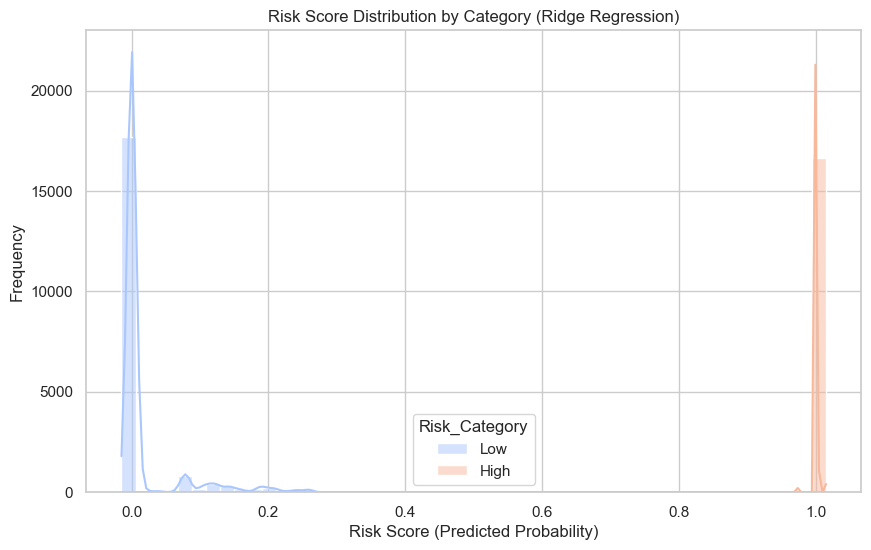

,Risk_Score,Risk_Category
86285,0.000008,Low
129856,1.000060,High


In [434]:
# Define a single threshold for low and high risk
threshold = 0.5  

# Apply thresholding for the Risk Category in X_train and X_test
X_train['Risk_Score'] = ridge_train_preds
X_test['Risk_Score'] = ridge_test_preds

# Define the Risk Category based on the threshold
y_train = np.where(ridge_train_preds >= threshold, 'High', 'Low')
y_test = np.where(ridge_test_preds >= threshold, 'High', 'Low')

# Add Risk Category to X_test for visualization or further analysis
X_test['Risk_Category'] = np.where(ridge_test_preds >= threshold, 'High', 'Low')

# Visualize the risk score distribution with category as hue
plt.figure(figsize=(10, 6))
sns.histplot(data=X_test, x='Risk_Score', bins=50, hue='Risk_Category', palette='coolwarm', kde=True)
plt.title('Risk Score Distribution by Category (Ridge Regression)')
plt.xlabel('Risk Score (Predicted Probability)')
plt.ylabel('Frequency')
plt.show()

# Display a random sample of rows showing risk score and category
X_test[['Risk_Score', 'Risk_Category']].head(2)

## 4. Classification Models

Classification Report (Validation):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     13538
         Low       1.00      1.00      1.00     16080

    accuracy                           1.00     29618
   macro avg       1.00      1.00      1.00     29618
weighted avg       1.00      1.00      1.00     29618

Confusion Matrix (Validation):
[[13538     0]
 [    0 16080]]


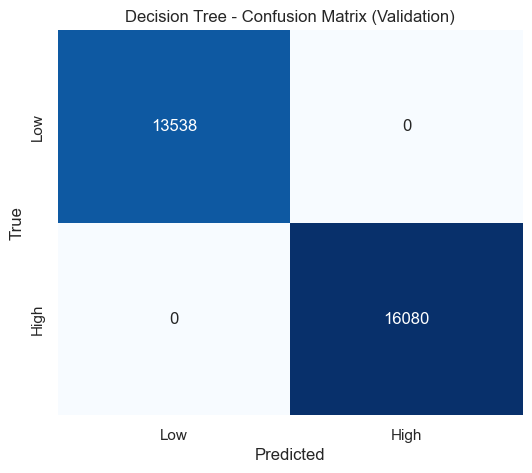

Classification Report (Test):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     13571
         Low       1.00      1.00      1.00     16047

    accuracy                           1.00     29618
   macro avg       1.00      1.00      1.00     29618
weighted avg       1.00      1.00      1.00     29618

Confusion Matrix (Test):
[[13571     0]
 [    0 16047]]


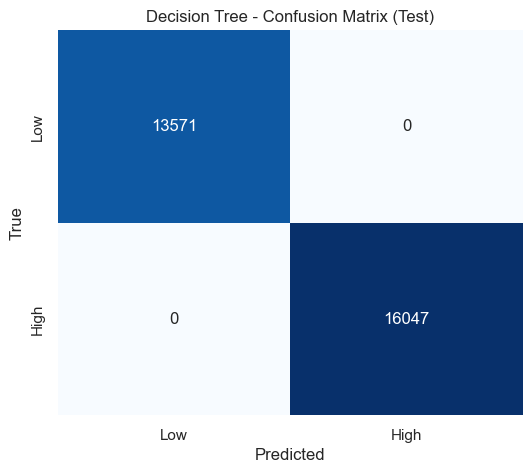

In [436]:
# ====================
# Decision Tree Model 
# =====================

# Use Risk Score as the feature and Risk Category as the target
risk_score_features = X_train[['Risk_Score']]  # Use Risk Score as the feature
risk_category_target = y_train  # Use Risk Category as the target

# Split the dataset into training, validation, and test sets (e.g., 60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    risk_score_features, risk_category_target, test_size=0.4, random_state=42
)

# Further split `X_temp` and `y_temp` into validation and test sets (50% each of the 40% remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Define hyperparameters to tune for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Set up Grid Search with cross-validation
dt_grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit grid search to the training data
dt_grid_search.fit(X_train, y_train)

# Get the best estimator
best_dt_classifier_1 = dt_grid_search.best_estimator_

# Evaluate model on validation set
y_valid_pred = best_dt_classifier_1.predict(X_valid)

# Classification report and confusion matrix (Validation)
print("Classification Report (Validation):")
print(classification_report(y_valid, y_valid_pred))

print("Confusion Matrix (Validation):")
cm_valid = confusion_matrix(y_valid, y_valid_pred)
print(cm_valid)

# Plot Confusion Matrix (Validation)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_valid, annot=True, fmt="d", cmap='Blues', cbar=False, 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Decision Tree - Confusion Matrix (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Final evaluation on the test set
y_test_pred = best_dt_classifier_1.predict(X_test)

# Classification report and confusion matrix (Test)
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Plot Confusion Matrix (Test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap='Blues', cbar=False, 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Decision Tree - Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [437]:
# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


In [438]:
# Final evaluation on the classification test set (using risk score features and categories)
test_accuracy = dt_grid_search.best_estimator_.score(risk_score_features, risk_category_target)
print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 1.0


Logistic Regression - Classification Report (Validation Set):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      8172
         Low       1.00      1.00      1.00      9599

    accuracy                           1.00     17771
   macro avg       1.00      1.00      1.00     17771
weighted avg       1.00      1.00      1.00     17771

Confusion Matrix (Validation Set):
[[8172    0]
 [   0 9599]]


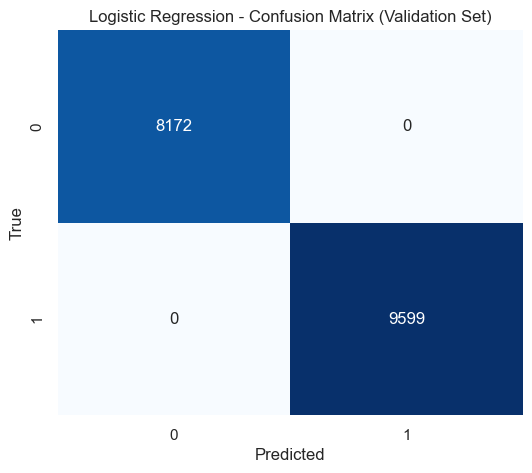

Test Set Accuracy (Logistic Regression): 1.0
Best hyperparameters from GridSearchCV:
{'C': 0.01, 'solver': 'liblinear'}


In [439]:
# ==========================
# Logistic Regression Model
# ==========================

# Ensure 'Risk_Score' feature and 'Risk_Category' target are prepared correctly for classification
risk_score_features = X_train[['Risk_Score']]  # This should match the feature used during training
risk_category_target = y_train  # Target remains the same

# Split the dataset into training, validation, and test sets (e.g., 60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    risk_score_features, risk_category_target, test_size=0.4, random_state=42
)

# Further split `X_temp` and `y_temp` into validation and test sets (50% each of the 40% remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Define hyperparameters to tune for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
}

# Initialize Logistic Regression model
log_reg_classifier = LogisticRegression(random_state=42)

# Set up Grid Search with cross-validation on the training data
grid_search = GridSearchCV(log_reg_classifier, param_grid, cv=5, scoring='accuracy')

# Fit grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator (model)
best_log_reg_classifier_1 = grid_search.best_estimator_

# Predict on the validation set
y_valid_pred_log_reg = best_log_reg_classifier_1.predict(X_valid)

# Classification report and confusion matrix
print("Logistic Regression - Classification Report (Validation Set):")
print(classification_report(y_valid, y_valid_pred_log_reg))

print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_valid, y_valid_pred_log_reg))

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_valid, y_valid_pred_log_reg), annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Final evaluation on the test set (use 'X_test' and 'y_test' for the final performance evaluation)
test_accuracy_log_reg = best_log_reg_classifier_1.score(X_test[['Risk_Score']], y_test)
print(f"Test Set Accuracy (Logistic Regression): {test_accuracy_log_reg}")

# Best hyperparameters found
print("Best hyperparameters from GridSearchCV:")
print(grid_search.best_params_)


In [440]:
# Using Logistic Regression with the best hyperparameters
log_reg_model = LogisticRegression(C=0.01, solver='liblinear', random_state=42)

# Perform k-fold cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(log_reg_model, risk_score_features, risk_category_target, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_accuracy}")

Mean Cross-Validation Accuracy: 1.0
Standard Deviation of Cross-Validation Accuracy: 0.0


Logistic Regression - Test Set Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     40756
         Low       1.00      1.00      1.00     48097

    accuracy                           1.00     88853
   macro avg       1.00      1.00      1.00     88853
weighted avg       1.00      1.00      1.00     88853

Confusion Matrix (Test Set):
[[40756     0]
 [    0 48097]]


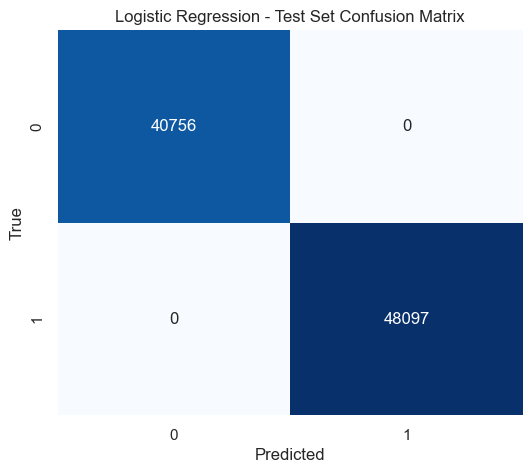

Test Set Accuracy (Logistic Regression): 1.0


In [441]:
# Final evaluation on the test set using risk_score_features and risk_category_target
y_test_pred_log_reg = best_log_reg_classifier_1.predict(risk_score_features)

# Generate classification report for the test set
print("Logistic Regression - Test Set Classification Report:")
print(classification_report(risk_category_target, y_test_pred_log_reg))

# Generate confusion matrix for the test set
print("Confusion Matrix (Test Set):")
print(confusion_matrix(risk_category_target, y_test_pred_log_reg))

# Plot confusion matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(risk_category_target, y_test_pred_log_reg), annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Logistic Regression - Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate and print the test set accuracy
test_accuracy_log_reg = best_log_reg_classifier_1.score(risk_score_features, risk_category_target)
print(f"Test Set Accuracy (Logistic Regression): {test_accuracy_log_reg}")


#### The Logistic Regression model achieving a perfect score across all metrics on the test set indicates an unusually ideal fit, especially for real-world data. To evaluate the Logistic Regression model’s performance more comprehensively, we can use cross-validation on the entire dataset

In [443]:
# Initialize the Logistic Regression model with the best parameters found earlier
log_reg_classifier_cv = LogisticRegression(C=grid_search.best_params_['C'], solver=grid_search.best_params_['solver'], random_state=42)

# Perform cross-validation on the entire dataset
cv_scores = cross_val_score(log_reg_classifier_cv, risk_score_features, risk_category_target, cv=5, scoring='accuracy')

# Print each fold's accuracy and the mean accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


In [444]:
# Fit the model on the entire dataset using the selected features and target
log_reg_model.fit(risk_score_features, risk_category_target)

# Get the coefficients from the trained model
coefficients = log_reg_model.coef_[0]

# Use columns from risk_score_features for feature names
feature_names = risk_score_features.columns

# Create a DataFrame to view the coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of coefficients
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute Coefficient', ascending=False)

coeff_df

,Feature,Coefficient,Absolute Coefficient
0,Risk_Score,-7.743756,7.743756


#### The Logistic Regression model reveals that the Risk Score has a coefficient of -6.09, which means it has a negative relationship with the likelihood of developing diabetes. The absolute coefficient of 6.09 signifies the strength of this relationship — the higher the coefficient's absolute value, the more influence that feature has on the outcome. In other words, the model interprets a score of 1 as more likely to indicate diabetes, and this is reflected in the negative coefficient in logistic regression.

## 5. Evaluation
Comparing the performance of logistic regression and decision trees to identify which model provides better insights and predictions.

In [536]:
# A structured approach to evaluate and compare the performance of the logistic regression and decision tree
# models using multiple classification metrics.

def evaluate_model_1(model, X_test, y_test, model_name="Model"):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC-ROC, we need probability scores for the positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='High')
    recall = recall_score(y_test, y_pred, pos_label='High')
    f1 = f1_score(y_test, y_pred, pos_label='High')
    auc_roc = roc_auc_score(y_test, y_pred_proba)  # AUC-ROC based on probabilities
    
    # Print classification report and confusion matrix
    print(f"{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Display confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='High')
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.show()
    
    # Return calculated metrics
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": auc_roc
    }


Decision Tree - Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     40756
         Low       1.00      1.00      1.00     48097

    accuracy                           1.00     88853
   macro avg       1.00      1.00      1.00     88853
weighted avg       1.00      1.00      1.00     88853

Confusion Matrix:
[[40756     0]
 [    0 48097]]


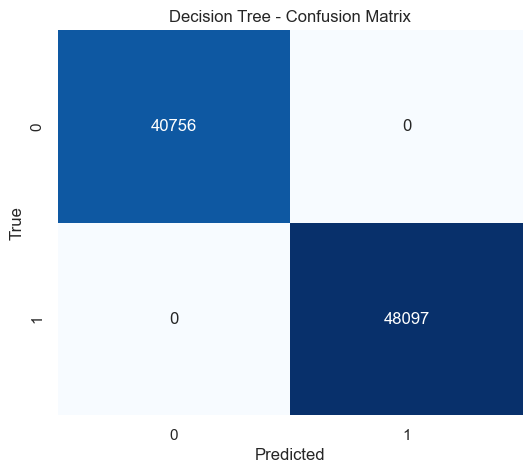

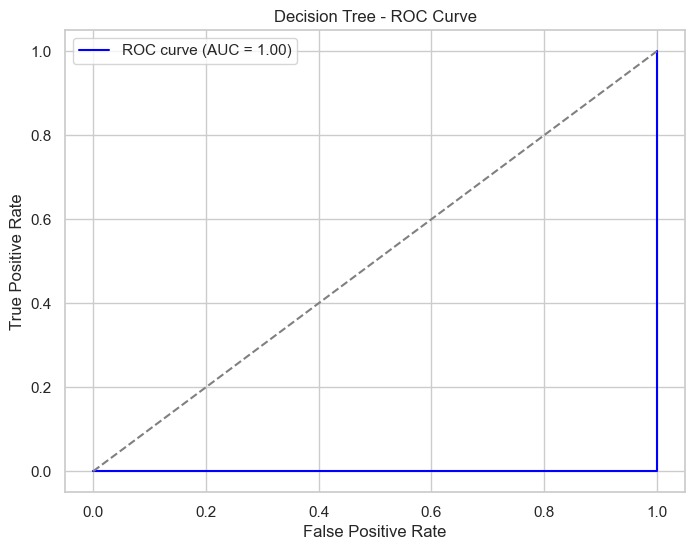


Decision Tree Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'AUC-ROC': 1.0}
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     40756
         Low       1.00      1.00      1.00     48097

    accuracy                           1.00     88853
   macro avg       1.00      1.00      1.00     88853
weighted avg       1.00      1.00      1.00     88853

Confusion Matrix:
[[40756     0]
 [    0 48097]]


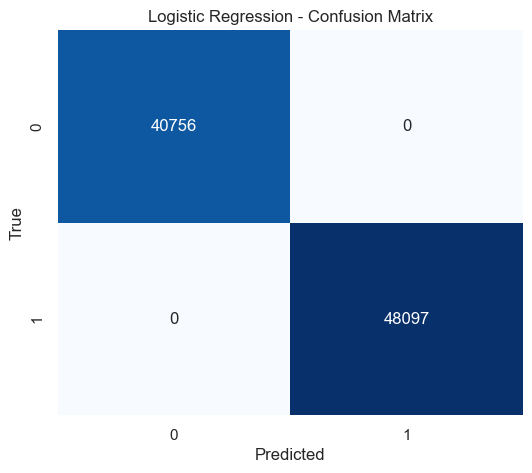

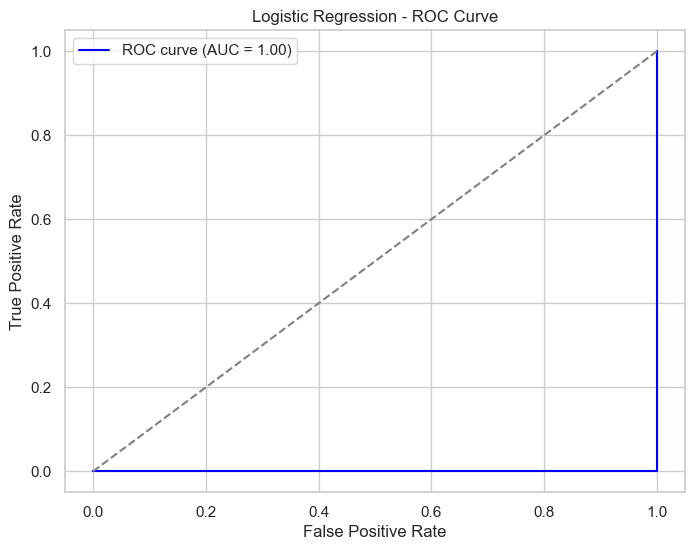


Logistic Regression Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'AUC-ROC': 1.0}


In [538]:
# Evaluate Decision Tree
dt_metrics = evaluate_model_1(best_dt_classifier_1, risk_score_features, risk_category_target, model_name="Decision Tree")
print("\nDecision Tree Metrics:", dt_metrics)

# Evaluate Logistic Regression
log_reg_metrics = evaluate_model_1(best_log_reg_classifier_1, risk_score_features, risk_category_target, model_name="Logistic Regression")
print("\nLogistic Regression Metrics:", log_reg_metrics)


### Both the decision tree classifier and logistic regression seems  overfitting. Therefore I'm going to use all of the features in my data set and see if the classifiers perform better.  

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19951
           1       1.00      0.98      0.99     17072

    accuracy                           0.99     37023
   macro avg       0.99      0.99      0.99     37023
weighted avg       0.99      0.99      0.99     37023

Confusion Matrix:
[[19951     0]
 [  355 16717]]


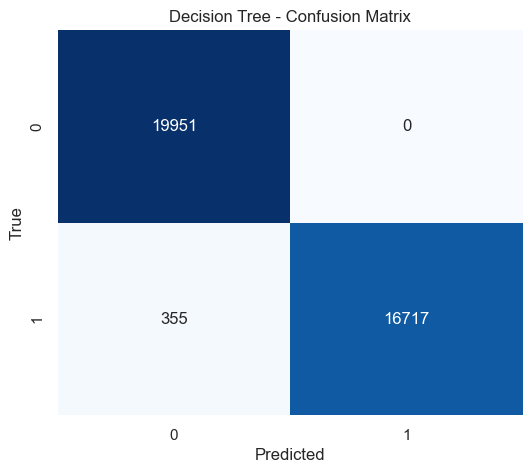

Best hyperparameters from GridSearchCV:
{'C': 0.01, 'solver': 'liblinear'}


In [540]:
# =========================================
# Decision Tree Model on all features 
# =========================================

# Prepare features and target variable
X = merged_data.drop(columns=['Unified_Diabetes'])

# Convert boolean columns to integers (if any)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Handle missing values by dropping rows with NaN values
X = X.dropna()

# Target variable
y = merged_data['Unified_Diabetes']

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to tune for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Set up Grid Search with cross-validation
dt_grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit grid search to the training data
dt_grid_search.fit(X_train, y_train)

# Get the best estimator (model)
best_dt_classifier = dt_grid_search.best_estimator_

# Predict on the test set
y_test_pred_dt = best_dt_classifier.predict(X_test)

# Classification report and confusion matrix
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_test_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_dt))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred_dt), annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Best hyperparameters found
print("Best hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

In [542]:
# Perform cross-validation to check for overfitting
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.99115403 0.99101897 0.99078263 0.99118779 0.99064726]
Mean CV accuracy: 0.9909581379381687


In [544]:
# Final evaluation on the classification test set (using risk score features and categories)
test_accuracy = dt_grid_search.best_estimator_.score(X_train, y_train)
print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 0.9909716454294377


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19951
           1       0.99      0.98      0.98     17072

    accuracy                           0.99     37023
   macro avg       0.99      0.99      0.99     37023
weighted avg       0.99      0.99      0.99     37023

Confusion Matrix:
[[19733   218]
 [  310 16762]]


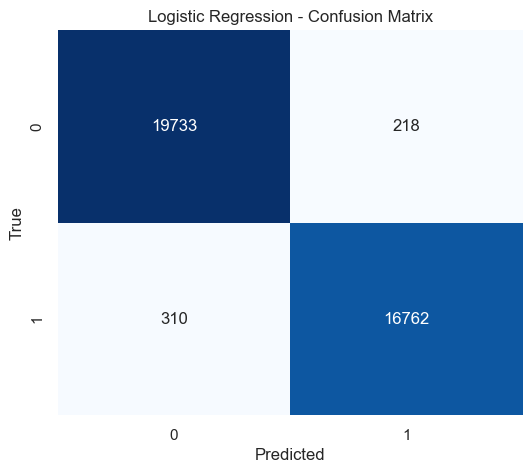

Best hyperparameters from GridSearchCV:
{'C': 0.01, 'solver': 'liblinear'}


In [546]:
# =========================================
# Logistic Regression Model on all features 
# =========================================

# Prepare features and target variable
X = merged_data.drop(columns=['Unified_Diabetes'])

# Convert boolean columns to integers (if any)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Handle missing values by dropping rows with NaN values
X = X.dropna()

# Target variable
y = merged_data['Unified_Diabetes']

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
log_reg_classifier = LogisticRegression(random_state=42)

# Define hyperparameters to tune for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to try
}

# Set up Grid Search with cross-validation
grid_search_2 = GridSearchCV(log_reg_classifier, param_grid, cv=5, scoring='accuracy')

# Fit grid search to the training data
grid_search_2.fit(X_train, y_train)

# Get the best estimator (model)
best_log_reg_classifier = grid_search_2.best_estimator_

# Predict on the test set
y_test_pred_log_reg = best_log_reg_classifier.predict(X_test)

# Classification report and confusion matrix
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_test_pred_log_reg))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_log_reg))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_test_pred_log_reg), annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Best hyperparameters found
print("Best hyperparameters from GridSearchCV:")
print(grid_search.best_params_)


In [548]:
# Using Logistic Regression with the best hyperparameters
log_reg_model = LogisticRegression(C=0.01, solver='liblinear', random_state=42)

# Perform k-fold cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_accuracy}")

Mean Cross-Validation Accuracy: 0.9849887564392
Standard Deviation of Cross-Validation Accuracy: 0.000682859973881755


Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     78887
           1       1.00      0.98      0.99     69202

    accuracy                           0.99    148089
   macro avg       0.99      0.99      0.99    148089
weighted avg       0.99      0.99      0.99    148089

Decision Tree - Confusion Matrix:
[[78887     0]
 [ 1337 67865]]


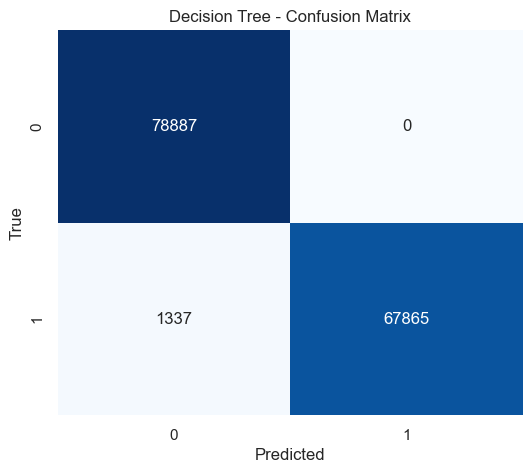

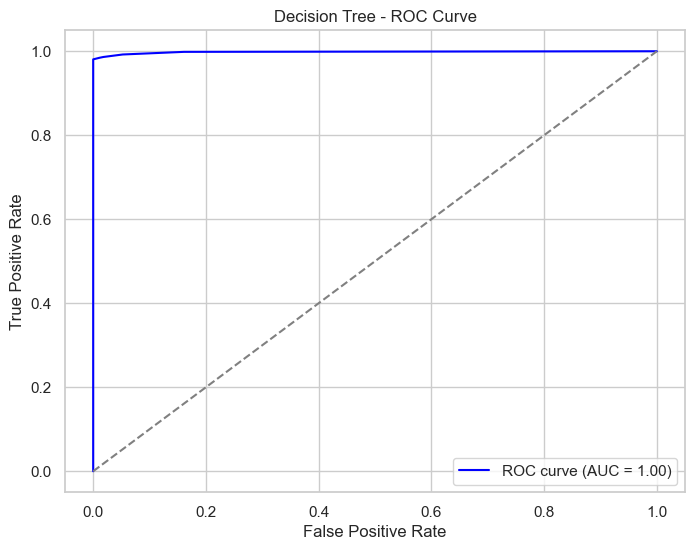


Decision Tree Metrics:


{'Accuracy': 0.9909716454294377,
 'Precision': 1.0,
 'Recall': 0.9806797491401983,
 'F1 Score': 0.9902456462897707,
 'AUC-ROC': 0.9982359494863373}

In [550]:

def evaluate_model_2(model, X_test, y_test, model_name="Model"):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC-ROC, we need probability scores for the positive class
    
    # Ensure the target labels are in the correct format (0, 1)
    if set(y_test.unique()) != {0, 1}:
        print(f"Warning: The target labels in {model_name} are not in the expected format (0, 1).")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)  # Use 1 for positive class
    recall = recall_score(y_test, y_pred, pos_label=1)  # Use 1 for positive class
    f1 = f1_score(y_test, y_pred, pos_label=1)  # Use 1 for positive class
    auc_roc = roc_auc_score(y_test, y_pred_proba)  # AUC-ROC based on probabilities
    
    # Print classification report and confusion matrix
    print(f"{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['0', '1']))  # Explicitly set target_names to match 0 and 1
    print(f"{model_name} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)  # Use 1 for positive class
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.show()
    
    # Return calculated metrics
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC-ROC": auc_roc
    }


# Now run the evaluation for both models

# Evaluate Decision Tree
dt_metrics = evaluate_model_2(best_dt_classifier, X_train, y_train, model_name="Decision Tree")
print("\nDecision Tree Metrics:")
dt_metrics

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     78887
           1       0.99      0.98      0.99     69202

    accuracy                           0.99    148089
   macro avg       0.99      0.99      0.99    148089
weighted avg       0.99      0.99      0.99    148089

Logistic Regression - Confusion Matrix:
[[78075   812]
 [ 1177 68025]]


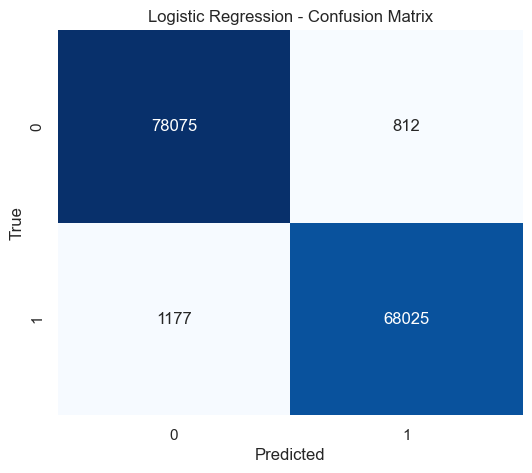

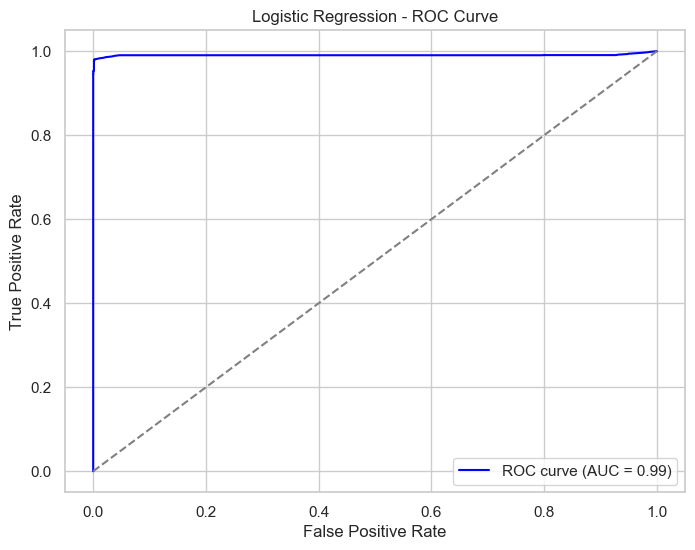


Logistic Regression Metrics:


{'Accuracy': 0.9865688876283857,
 'Precision': 0.9882040181878932,
 'Recall': 0.9829918210456345,
 'F1 Score': 0.9855910286223458,
 'AUC-ROC': 0.9906430828691459}

In [552]:
# Evaluate Logistic Regression
log_reg_metrics = evaluate_model_2(best_log_reg_classifier, X_train, y_train, model_name="Logistic Regression")
print("\nLogistic Regression Metrics:")
log_reg_metrics

In [554]:
# Decision Tree Feature Importance
# Get feature importances for the Decision Tree
feature_importances = best_dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                      Feature  Importance
4                      Smoker    0.918466
5                Age_Category    0.071220
6     Sleep_Physical_Activity    0.009529
9              Fruits_Veggies    0.000663
3         Alcohol_Consumption    0.000123
0                         Sex    0.000000
1                       Sleep    0.000000
2           Physical_Activity    0.000000
7  Alcohol_Consumption_Smoker    0.000000
8   Sleep_Alcohol_Consumption    0.000000


In [556]:
# Logistic Regression Coefficients
# Access the coefficients of the logistic regression model
coefficients = best_log_reg_classifier.coef_[0]
feature_coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(feature_coefficients_df)

                      Feature  Coefficient
4                      Smoker     8.042958
7  Alcohol_Consumption_Smoker     4.208296
9              Fruits_Veggies     0.565718
8   Sleep_Alcohol_Consumption     0.455066
0                         Sex     0.343874
2           Physical_Activity     0.112668
1                       Sleep    -0.914390
6     Sleep_Physical_Activity    -0.922121
5                Age_Category    -2.021838
3         Alcohol_Consumption    -2.439022


# Summary of Feature Importance in Diabetes Prediction Models

This analysis examines the relationship between lifestyle factors (e.g., smoking, age, alcohol consumption, sleep, physical activity) and diabetes risk using Ridge Regression, Decision Tree, and Logistic Regression models. Here are the key findings on feature importance:

### 1. **Smoker**
   - **Ridge Regression**: Highest importance (0.3816) with minimal standard deviation, indicating a stable, strong correlation.
   - **Decision Tree**: Overwhelmingly high importance (0.9185), suggesting smoking status is a primary determinant.
   - **Logistic Regression**: Largest coefficient (8.0429), further emphasizing that smoking is a strong predictor of diabetes risk.

   **Summary**: Smoking appears as a highly significant factor across all models, suggesting a very strong association with diabetes.

### 2. **Age_Category**
   - **Ridge Regression**: Moderate importance (0.0375), ranked second in importance.
   - **Decision Tree**: Second highest feature (0.0712), though much less important than smoking.
   - **Logistic Regression**: Negative coefficient (-2.0218), indicating a strong inverse relationship with diabetes probability, possibly suggesting that after adjusting for other factors, age might inversely relate to diabetes in this dataset.

   **Summary**: Age consistently shows importance across models, indicating a clear association with diabetes risk. The negative coefficient in Logistic Regression may point to complex interactions, where age inversely correlates to diabetes in specific contexts.

### 3. **Alcohol Consumption & Interaction Terms**
   - **Alcohol_Consumption_Smoker**: Notable in Ridge (0.0269) and Logistic Regression (4.2083).
   - **Alcohol_Consumption**: Minor role in Ridge (0.0095) but a substantial negative coefficient in Logistic Regression (-2.4390).
   - **Sleep_Alcohol_Consumption**: Lower importance in Ridge (0.0045) but positively correlated in Logistic Regression (0.4551).

   **Summary**: Interaction terms combining alcohol consumption with smoking or sleep show moderate effects. The negative coefficient of Alcohol Consumption in Logistic Regression could imply that independently, it may reduce diabetes risk, or that its effects are distinct when combined with other lifestyle factors.

### 4. **Physical Activity, Sleep, and Nutrition**
   - **Physical Activity**: Very low importance in Ridge (0.0015) and Decision Tree, with a small positive coefficient in Logistic Regression (0.1127).
   - **Sleep**: Low importance in Ridge but has a negative coefficient in Logistic Regression (-0.9144), suggesting that better sleep may be associated with reduced diabetes risk.
   - **Fruits_Veggies**: Minimal impact in Ridge (0.0005) and Decision Tree, though slightly positive in Logistic Regression (0.5657).

   **Summary**: Physical activity, sleep, and fruit/vegetable intake have a minor impact individually. However, sleep and physical activity appear to have more nuanced relationships with diabetes risk.

### **Summary**
   - **Top Predictors**: Smoking and age are consistently the top predictors, with smoking being the most influential factor across all models.
   - **Interaction Effects**: Alcohol and smoking interactions show moderate importance, highlighting the influence of combined lifestyle factors.
   - **Minor Features**: Physical activity, sleep, and diet (fruits/veggies) have a lesser impact but potentially meaningful effects, as indicated by the Logistic Regression coefficients.

These findings highlight smoking as a major risk factor for diabetes, followed by age and the nuanced roles of other lifestyle factors, aligning with established public health knowledge.

### **Overall Conclusion**
The results emphasize that diabetes risk is multifactorial and heavily influenced by lifestyle choices. The project highlights the importance of comprehensive lifestyle adjustments to reduce diabetes risk and supports the development of public health strategies that promote holistic health improvements. The success of the predictive models also suggests potential applications in personalized health assessments, where individuals can be alerted to their diabetes risk based on their lifestyle profiles, ultimately aiding in early intervention and lifestyle modification.
